# Biomedical Engineering Department

### Data Loading and Preprocessing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
data = pd.read_csv('data/raw_survey_data_2022.csv',header=None)

In [3]:
df = pd.read_csv('data/raw_survey_data_2022.csv',header=1)

### Data Cleaning

In [4]:
data.loc[0,data.iloc[0,:].str.contains('If you have read the survey up to this point')==True].index

Int64Index([176, 306], dtype='int64')

In [5]:
df_1=df[(df.iloc[:,176]=='2')&(df.iloc[:,306]=='4')]

In [6]:
## 2 response time more than 200s
def response_time(df,minimum=200):
    data1=df.iloc[:,1] #DataFrame with start time
    data2=df.iloc[:,2] #DataFrame with end time
    data3=df.iloc[:,3:] #DataFrame with data

    data3["time"]=data2.apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))-data1.apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))
    #(data1.iloc[:,1].values.astype('datetime64[D]')-data1.iloc[:,0].values.astype('datetime64[D]'))

                                                                                                    
    index_time= data3["time"].apply(lambda x: x/np.timedelta64(1, 's'))
    data3['clean']=(index_time>200)
    cleaned_data=data3.loc[data3.clean==True].iloc[:,:-2]

    return cleaned_data
cleaned_data_text=response_time(df_1,200)

cleaned_data_text.shape

(1271, 348)

In [17]:
## change some answer to numerical
def numeric_scale(cleaned_data_text):
    cleaned_data = cleaned_data_text.copy()
    for i in range(cleaned_data.shape[0]):
        for j in range(cleaned_data.shape[1]):
            if cleaned_data.iloc[i,j] in ['Strongly agree','Strongly Agree']:
                cleaned_data.iloc[i,j]=5
            if cleaned_data.iloc[i,j]=='Agree':
                cleaned_data.iloc[i,j]=4
            if cleaned_data.iloc[i,j]in['Neither agree or disagree','Neither agree nor disagree','Neither disagree nor agree']:
                cleaned_data.iloc[i,j]=3
            if cleaned_data.iloc[i,j]=='Disagree':
                cleaned_data.iloc[i,j]=2
            if cleaned_data.iloc[i,j]=='Strongly disagree':
                cleaned_data.iloc[i,j]=1
    return cleaned_data


cleaned_data=numeric_scale(cleaned_data_text)

In [18]:
def plot_3_cat(df_count):
        cmap = mpl.cm.Blues(np.linspace(0,0.9,100))
        cmap = mpl.colors.ListedColormap(cmap[10:,:-1])



        b_prob=(df_count).apply(lambda x: x / x.sum(), axis=0)
        b_prob =b_prob[(b_prob.iloc[2:,:].sum()).sort_values().index]
        aaa=(b_prob[(b_prob.iloc[2:,:].sum()).sort_values().index]).T
        bbb=b_prob.T

        fig,ax=plt.subplots(figsize=(8,6),dpi=300)
        b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
        plt.legend(['Agree','Neither agree \n nor disagree','Disagree'][::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
        ax.set_xlabel("Proportion",fontsize=12)
        for n, x in enumerate([*aaa.index.values]):
            m=3
            for (proportion, count, y_loc) in zip(bbb.loc[x],
                                              aaa.loc[x],
                                              bbb.loc[x].cumsum()):

                if m<2:
                     plt.text(x=(y_loc - proportion) + (proportion / 2),
                     y=n - 0.11,
                     s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                              #s=f'{str(count).split(".")[0]}', 
                     color="white",
                     fontsize=8,
                     fontweight="bold")
                if m>=2:

                    plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                     y=n - 0.11,
                     s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                             #s=f'{str(count).split(".")[0]}', 
                     color="black",
                     fontsize=8,
                     fontweight="bold")
                m-=1
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)


        plt.show()
        return ax

### Question 2022

In [19]:
# create the table of the first 2 rows to see the questions and the columns they locate
Q=data.iloc[:2,3:].T
Q.columns=['Question','Sub_Question']
#Q['location']=[ lambda x: x.index*(x.Question.isna()==False)]
Q=Q.reset_index(drop=True)
Q['location']=np.where(Q.Question.isna()==False, Q.Question.index, "False")

In [20]:
# Main questions
qq=Q[Q['location']!='False']
qq=qq.reset_index(drop=True)

### Question 2019

In [21]:
data2019 = pd.read_csv('data/Copy of de-identified Graduate Student Quality of Life Survey - Spring 2019.xlsx \
- Graduate Student Quality of Lif.csv',header=None)

In [22]:
# create the table of the first 2 rows to see the questions and the columns they locate
Q2019=data2019.iloc[:2,3:].T
Q2019.columns=['Question','Sub_Question']
#Q['location']=[ lambda x: x.index*(x.Question.isna()==False)]
Q2019=Q2019.reset_index(drop=True)
Q2019['location']=np.where(Q2019.Question.isna()==False, Q2019.Question.index, "False")

In [23]:
#Q2019.to_csv("output/Questions-19.csv", index=True)

In [24]:
##Find dataset for queryed text

def query_data(Q,qq,cleaned_data,query,indx):
    que=Q[Q['Question'].str.contains(query)==True]
    val=que.values
    ind=que.index.values
    print(Q.loc[ind[indx-1],'Question'])
    start=ind[indx-1]
    end=int(qq.iloc[qq[qq.location==str(ind[indx-1])].index+1]['location'])
    df_return=cleaned_data.iloc[:,start:end]
    return df_return

In [25]:
degree=query_data(Q,qq,cleaned_data,'Current Academic Program',indx=1)
department=query_data(Q,qq,cleaned_data,'current academic department',indx=1)
gender=query_data(Q,qq,cleaned_data,'gender',indx=3)
LGBTQ=query_data(Q,qq,cleaned_data,'LGBTQ',indx=1)
ethnic=query_data(Q,qq,cleaned_data,'ethnic',indx=1)
country=query_data(Q,qq,cleaned_data,'Country',indx=1)
age=query_data(Q,qq,cleaned_data,'age',indx=3)

Current Academic Program
What is your current academic department or institute?
Please indicate the gender(s) with which you identify (check all that apply):
Do you identify yourself as part of the LGBTQ community?
Please identify your ethnic background.
Country of Origin
What is your current age?


In [26]:
department.value_counts()

Response.3                                    
Industrial Engineering and Operations Research    314
Computer Science                                  274
Electrical Engineering                            148
Biomedical Engineering                            138
Mechanical Engineering                             95
Data Science Institute                             76
Chemical Engineering                               68
Civil Engineering and Engineering Mechanics        62
Applied Physics and Applied Mathematics            58
Earth and Environmental Engineering                29
I prefer not to answer.                             9
dtype: int64

In [27]:
data_2019 = pd.read_csv('data/Copy of de-identified Graduate Student Quality of Life Survey - Spring 2019.xlsx \
- Graduate Student Quality of Lif.csv',header=1)
# use the same way to clean 2019 data
print(data_2019.shape)
cleaned_data_2019_text=response_time(data_2019,200)
print(cleaned_data_2019_text.shape)
d2019=numeric_scale(cleaned_data_2019_text)

(1033, 345)
(997, 342)


In [28]:
department2019=query_data(Q,qq,d2019,'current academic department',indx=1)
department2019.value_counts()

What is your current academic department or institute?


Response.3                                    
Industrial Engineering and Operations Research    243
Computer Science                                  150
Electrical Engineering                            116
Civil Engineering and Engineering Mechanics        88
Biomedical Engineering                             87
Mechanical Engineering                             81
Data Science Institute                             70
Applied Physics and Applied Mathematics            56
Chemical Engineering                               49
Earth and Environmental Engineering                38
I prefer not to answer.                             9
dtype: int64

### Creating features

In [29]:
cleaned_data['department']=department
cleaned_data['degree']=degree
#cleaned_data['gender']=gender
#cleaned_data['LGBTQ']=LGBTQ

In [30]:
degree2019=query_data(Q,qq,d2019,'Current Academic Program',indx=1)
gender2019=query_data(Q,qq,d2019,'gender',indx=3)
LGBTQ2019=query_data(Q,qq,d2019,'LGBTQ',indx=1)

Current Academic Program
Please indicate the gender(s) with which you identify (check all that apply):
Do you identify yourself as part of the LGBTQ community?


In [31]:
d2019['department']=department2019
d2019['degree']=degree2019
#cleaned_data_2019['gender']=gender2019
#cleaned_data_2019['LGBTQ']=LGBTQ2019

#### Create Dataset for ME only

In [84]:
df2022_ME=cleaned_data[cleaned_data['department']=='Data Science Institute'].copy()
df2019_ME=d2019[d2019['department']=='Data Science Institute'].copy()

In [33]:
#df2019_ME.columns=pd.MultiIndex.from_tuples(zip((Q2019['Question']).append(pd.Series(['department','degree'],index=[342, 343])), df2019_ME.columns), names=["first", "second"])
#df2022_ME.columns=pd.MultiIndex.from_tuples(zip((Q['Question']).append(pd.Series(['department','degree'],index=[348, 349])), df2022_ME.columns), names=["first", "second"])


In [34]:
#df2019.to_csv('BMEN/Response2019.csv')

In [35]:
#df2022.to_csv('BMEN/Response2022.csv')

## Basic Statistics

In [36]:
#df2019=pd.read_csv('BMEN/BMEN/Response2019.csv',header=[0, 1], skipinitialspace=True,index_col=0)
#df2022=pd.read_csv('BMEN/BMEN/Response2022.csv',header=[0, 1], skipinitialspace=True,index_col=0)

In [37]:
#df2019_ME

In [85]:
df2022_ME['degree'].value_counts().sum()

76

In [88]:
df2019_ME['degree'].value_counts().sum()

70

In [89]:
dg=pd.DataFrame(df2019_ME['degree'].value_counts())
dg.rename(columns={"degree":'2019'},inplace=True)
dg['2022']=df2022_ME['degree'].value_counts()
dg.rename(inplace=True,index={'Master of Science (M.S.)':'M.S.','Doctor of Philosophy (Ph.D.)':'Ph.D.'\
                                         ,'Doctor of Engineering Science (Eng.Sc.D.)':'Eng.Sc.D.'})

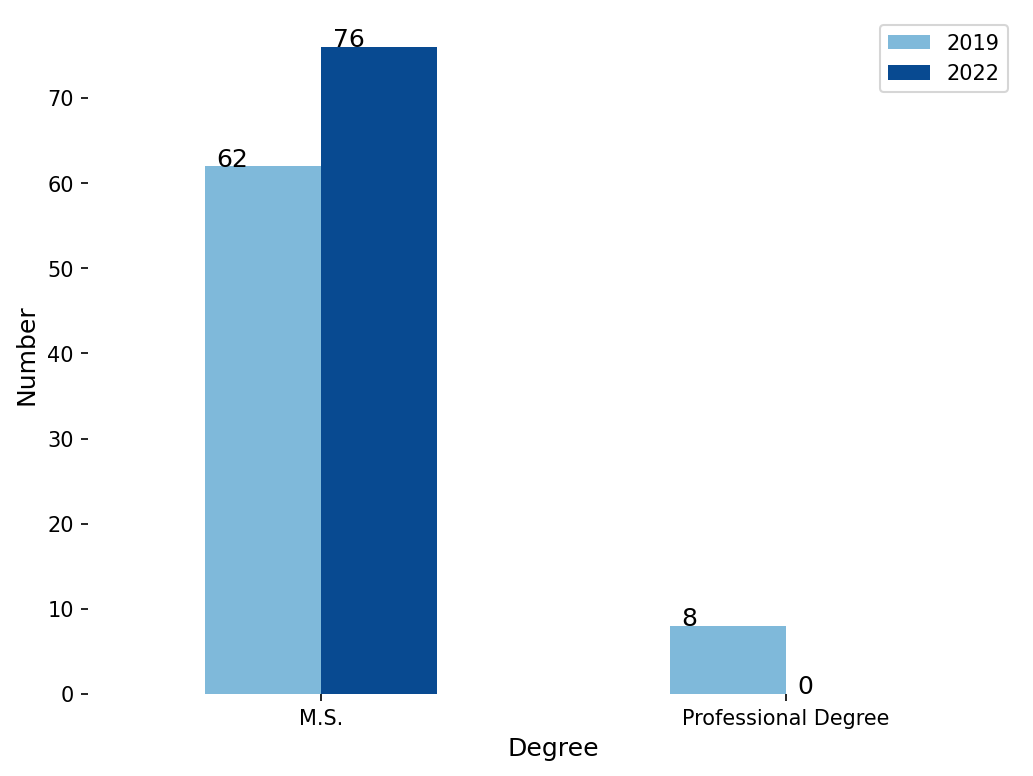

In [90]:
cmap = mpl.cm.Blues(np.linspace(0.4,0.9,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])
fig,ax=plt.subplots(figsize=(8,6),dpi=150)

dg.plot(kind='bar',colormap=cmap,ax=ax)

plt.ylabel("Number",fontsize=12)
plt.xlabel("Degree",fontsize=12)
#plt.title("Responded ME Students by Degree",fontsize=20)
plt.xticks(rotation=0)
x_offset = -0.1
y_offset = 0.0
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2+ x_offset, b.y1+y_offset),fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)




In [42]:
df2022_ME.replace('M.S. leading to Ph.D.','Doctor of Philosophy (Ph.D.)',inplace=True)#.value_counts()
degree= degree.replace('M.S. leading to Ph.D.','Doctor of Philosophy (Ph.D.)')

In [43]:
df2022_ME['degree'].value_counts()

Master of Science (M.S.)        62
Doctor of Philosophy (Ph.D.)    33
Name: degree, dtype: int64

### semesters enrolled

In [91]:
pd.DataFrame(query_data(Q,qq,df2022_ME,'semester',indx=1).value_counts())

Please indicate the number of full academic semesters you have been at Columbia as a graduate student:


,0
Response.2,
1 semester,35
2 semesters,26
3 semesters,12
4 semesters,3


In [45]:
df2019_ME_MS = df2019_ME[df2019_ME['degree']=='Master of Science (M.S.)']
df2022_ME_MS = df2022_ME[df2022_ME['degree']=='Master of Science (M.S.)']
df2019_ME_PHD = df2019_ME[df2019_ME['degree']=='Doctor of Philosophy (Ph.D.)']
df2022_ME_PHD = df2022_ME[df2022_ME['degree']=='Doctor of Philosophy (Ph.D.)']

In [46]:
#df2019_ME_MS.columns=pd.MultiIndex.from_tuples(zip((Q2019['Question']).append(pd.Series(['department','degree'],index=[342, 343])), df2019_ME_MS.columns), names=["first", "second"])
#df2022_ME_MS.columns=pd.MultiIndex.from_tuples(zip((Q['Question']).append(pd.Series(['department','degree'],index=[348, 349])), df2022_ME_MS.columns), names=["first", "second"])
#df2019_ME_PHD.columns=pd.MultiIndex.from_tuples(zip((Q2019['Question']).append(pd.Series(['department','degree'],index=[342, 343])), df2019_ME_PHD.columns), names=["first", "second"])
#df2022_ME_PHD.columns=pd.MultiIndex.from_tuples(zip((Q['Question']).append(pd.Series(['department','degree'],index=[348, 349])), df2022_ME_PHD.columns), names=["first", "second"])




## Satisfaction of MECE Department

In [79]:
sat2019=query_data(Q,qq,df2019_ME_PHD,'satisfied',indx=1)
sat2022=query_data(Q,qq,df2022_ME_PHD,'satisfied',indx=1)

I am satisfied with my overall experience at Columbia.
I am satisfied with my overall experience at Columbia.


In [80]:
print(f'Mean Satisfaction of 2019 is : {sat2019.mean().sum():0.3f}')
print(f'Mean Satisfaction of 2022 is : {sat2022.mean().sum():0.3f}')

Mean Satisfaction of 2019 is : 4.000
Mean Satisfaction of 2022 is : 3.852


In [51]:
a=pd.DataFrame(((sat2019.Response.value_counts()).sort_index(ascending=True)))
a.rename(columns={"Response":'2019'},inplace=True)
b=(sat2022.Response.value_counts()).sort_index(ascending=True)
a['2022']=(b)
a

,2019,2022
1,1,1
2,1,7
3,10,16
4,57,59
5,12,12


In [350]:
aa=a.apply(lambda x: x / x.sum(), axis=0)

In [351]:

ind=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree'][::-1]
aa.rename(index={1:ind[0],2:ind[1],3:ind[2],4:ind[3],5:ind[4]},inplace=True)


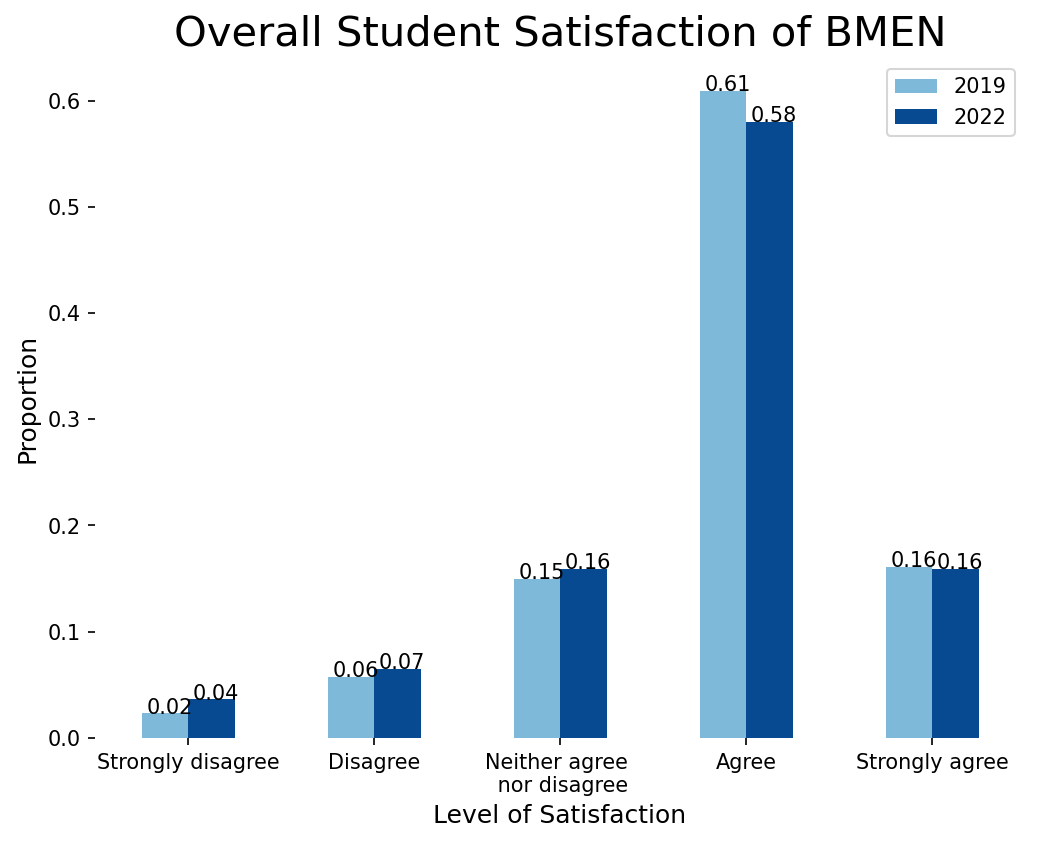

In [352]:
cmap = mpl.cm.Blues(np.linspace(0.4,0.9,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])
fig,ax=plt.subplots(figsize=(8,6),dpi=150)

aa.plot(kind='bar',colormap=cmap,ax=ax)

plt.ylabel("Proportion",fontsize=12)
plt.xlabel("Level of Satisfaction",fontsize=12)
plt.title("Overall Student Satisfaction of BMEN",fontsize=20)
plt.xticks(rotation=0)
x_offset = -0.1
y_offset = 0.0
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2+ x_offset, b.y1+y_offset),fontsize=10)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



### By degree 

In [92]:
df_satisfied= query_data(Q,qq,df2022_ME,'satisfied',indx=1)

I am satisfied with my overall experience at Columbia.


In [93]:
df_satisfied_degree=df_satisfied.copy()
df_satisfied_degree['degree']=degree
df_satisfied_degree['num']=1
dff=df_satisfied_degree.groupby(['degree','Response']).count().unstack('degree')
df_degree=dff['num']#/dfff.sum(axis=0)
#dff.to_csv("output/df_satisfied_degree.csv")
#df_degree=dff['num'].drop(columns='Professional Degree')
df_degree=df_degree.fillna(0)
#df_satisfied_degrea['Response']=df_satisfied_degree.Response.astype(int)
inner=df_satisfied_degree.groupby(['degree','Response']).sum()
outer = df_satisfied_degree.groupby('degree').sum()
outer

,num
degree,
Master of Science (M.S.),76


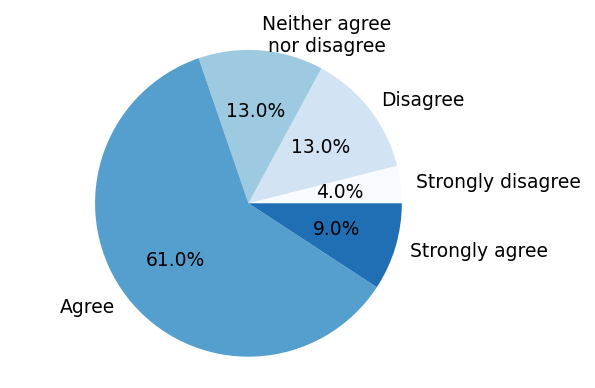

In [94]:
# Create a pieplot
indd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree']
indd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree']



fig,ax=plt.subplots(figsize=(4,3),dpi=150)
#plt.pie(np.array(df_degree.iloc[:,0]),color=cmap)
cmap = mpl.cm.Blues(np.linspace(0,1.7,10))
#cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

explode = (0, 0, 0, 0,0) 
_, _, autotexts =ax.pie(df_degree['Master of Science (M.S.)'], explode=explode, labels=indd[::-1], autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 1 else ' ',colors=cmap,
        shadow=False,textprops={'fontsize':9})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()



### 

## 

## 



## Satisfaction v.s Importance

In [95]:
important_2019=query_data(Q,qq,df2019_ME,"important",indx=1)
satisfied2_2019 = query_data(Q,qq,df2019_ME,"satisfied",indx=2)

The following are important with respect to my overall experience at Columbia.
I am satisfied with the following with respect to my overall experience at Columbia.


In [96]:
important_2022=query_data(Q,qq,df2022_ME,"important",indx=1)
satisfied2_2022 = query_data(Q,qq,df2022_ME,"satisfied",indx=2)

The following are important with respect to my overall experience at Columbia.
I am satisfied with the following with respect to my overall experience at Columbia.


In [97]:
a=pd.DataFrame(satisfied2_2022.mean()).T
b=pd.DataFrame(important_2022.mean()).T
b.columns=a.columns
c2022=pd.concat([a,b],ignore_index=True)
c2022

,Academics,Mental health,Physical health,Professional development,Social life,Career Placement Team,Housing,Intercampus Shuttle/Via Service,Library services,Funding opportunities,Student life and academic advising,Technology services and support
0,3.697368,3.394737,3.565789,3.736842,3.526316,3.486842,3.131579,3.855263,4.144737,2.789474,3.565789,3.776316
1,4.644737,4.342105,4.223684,4.434211,4.105263,4.447368,3.921053,3.947368,4.328947,4.197368,4.355263,4.184211


In [98]:
a=pd.DataFrame(satisfied2_2019.mean()).T
b=pd.DataFrame(important_2019.mean()).T
b.columns=a.columns
c2019=pd.concat([a,b],ignore_index=True)
c2019

,Academics,Mental health,Physical health,Professional development,Social life,Career services,Housing,Intercampus Shuttle,Library services,Funding opportunities,Student life and academic advising,Technology services and support
0,3.957143,3.371429,3.485714,3.957143,3.471429,3.900000,2.985714,3.371429,4.071429,2.900000,3.571429,3.857143
1,4.600000,4.000000,4.085714,4.400000,4.014286,4.442857,3.657143,3.114286,4.014286,3.614286,4.171429,3.957143


In [99]:
c2022.iloc[1,:].mean()

4.260964912280702

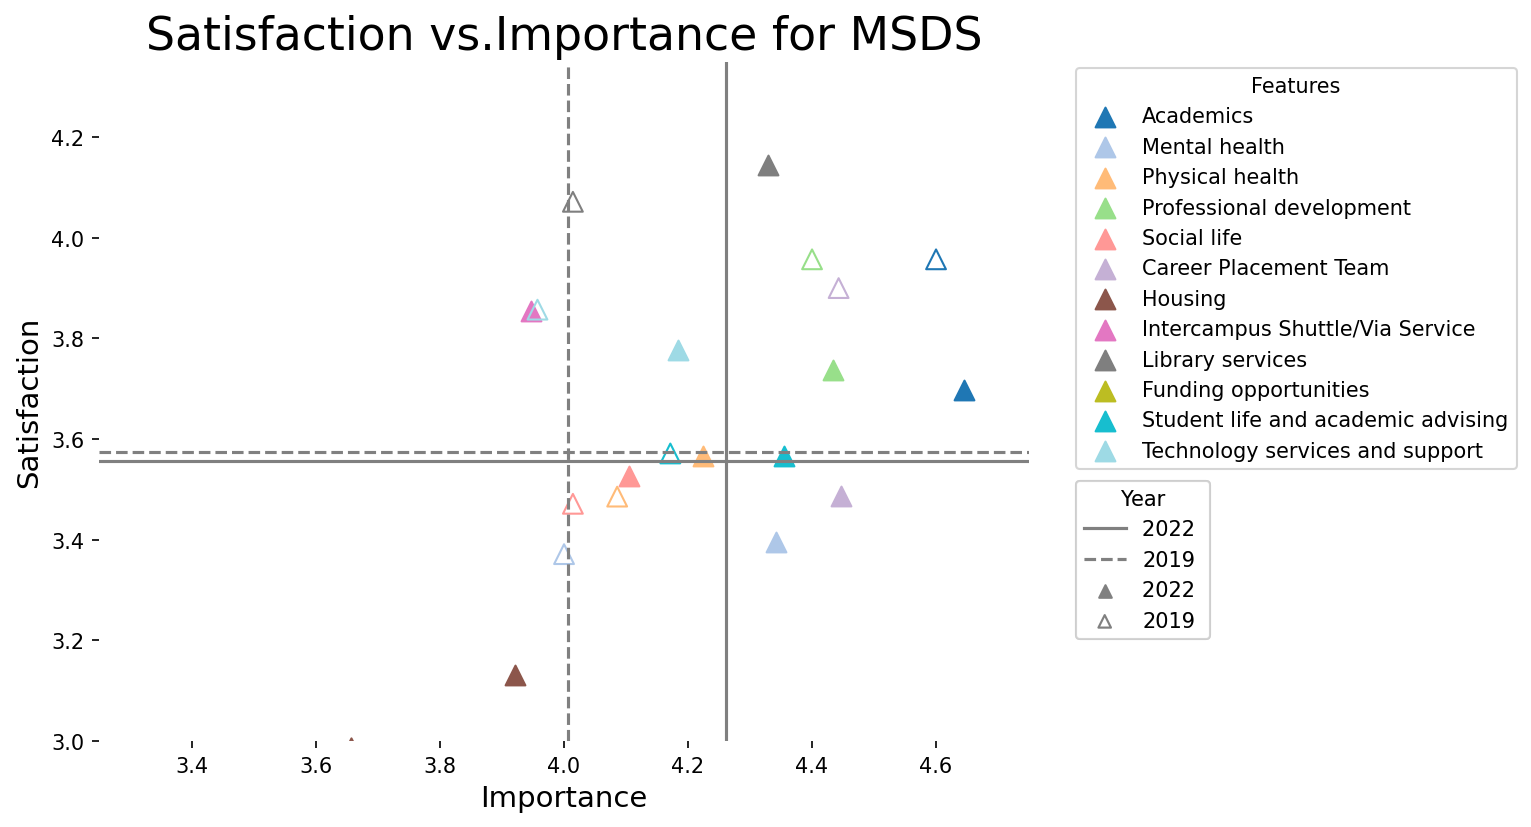

In [220]:
import matplotlib.cm as cm
colors = cm.tab20(np.linspace(0, 1, (12)))

fig,ax=plt.subplots(figsize=(8,6),dpi=150)

for i in range(12):
    ax.scatter(c2022.iloc[1,i],c2022.iloc[0,i],s=90,marker='^',label=c2022.columns[i],c=colors[i].reshape(1,-1))

for i in range(12):
    ax.scatter(c2019.iloc[1,i],c2019.iloc[0,i],s=90,marker='^',facecolors='none',edgecolors=colors[i].reshape(1,-1))

line1=ax.axhline(y=c2022.iloc[0,:].mean(),c='grey')
ax.axvline(x=c2022.iloc[1,:].mean(),c='grey' )

line2=ax.axhline(y=c2019.iloc[0,:].mean(),c='grey',ls='--')
ax.axvline(x=c2019.iloc[1,:].mean(),c='grey' ,ls='--')


ax.set_xlim([3.25, 4.750])
ax.set_ylim([3.0, 4.350])


ax.set_title("Satisfaction vs.Importance for MSDS",fontsize=22)

leg = plt.legend(loc=(1.05,0.4), title="Features")
ax.add_artist(leg)
#leg = plt.legend(,loc=(1.05,0.4), title="Year")


#import matplotlib.lines as mlines

import matplotlib.patches as mpatches

grey_triangle1 = ax.scatter([], [], color='grey', marker='^', linestyle='None')
grey_triangle2 = ax.scatter([], [], color='grey', marker='^', facecolors='none',edgecolors="grey",linestyle='None')

#first_legend=plt.legend([line1,line2],['2022','2019'],bbox_to_anchor=(1, 1.05))
leg1=plt.legend(handles=[line1,line2,grey_triangle1,grey_triangle2], labels=['2022 ','2019','2022 ','2019'],loc=(1.05,0.15), title="Year")
ax.add_artist(leg1)

ax.set_xlabel("Importance",fontsize=14)
ax.set_ylabel("Satisfaction",fontsize=14)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



plt.show()

## Academics

In [120]:
aca_import_2019=query_data(Q,qq,df2019_ME,"academics",indx=1)
aca_import_2022=query_data(Q,qq,df2022_ME,"academics",indx=1)
aca_import_2022['degree']=degree
aca_import_2022c=aca_import_2022.copy()

The following are important with respect to my overall satisfaction with SEAS classes and academics.
The following are important with respect to my overall satisfaction with SEAS classes and academics.


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_15751/1281218802.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aca_import_2022['degree']=degree


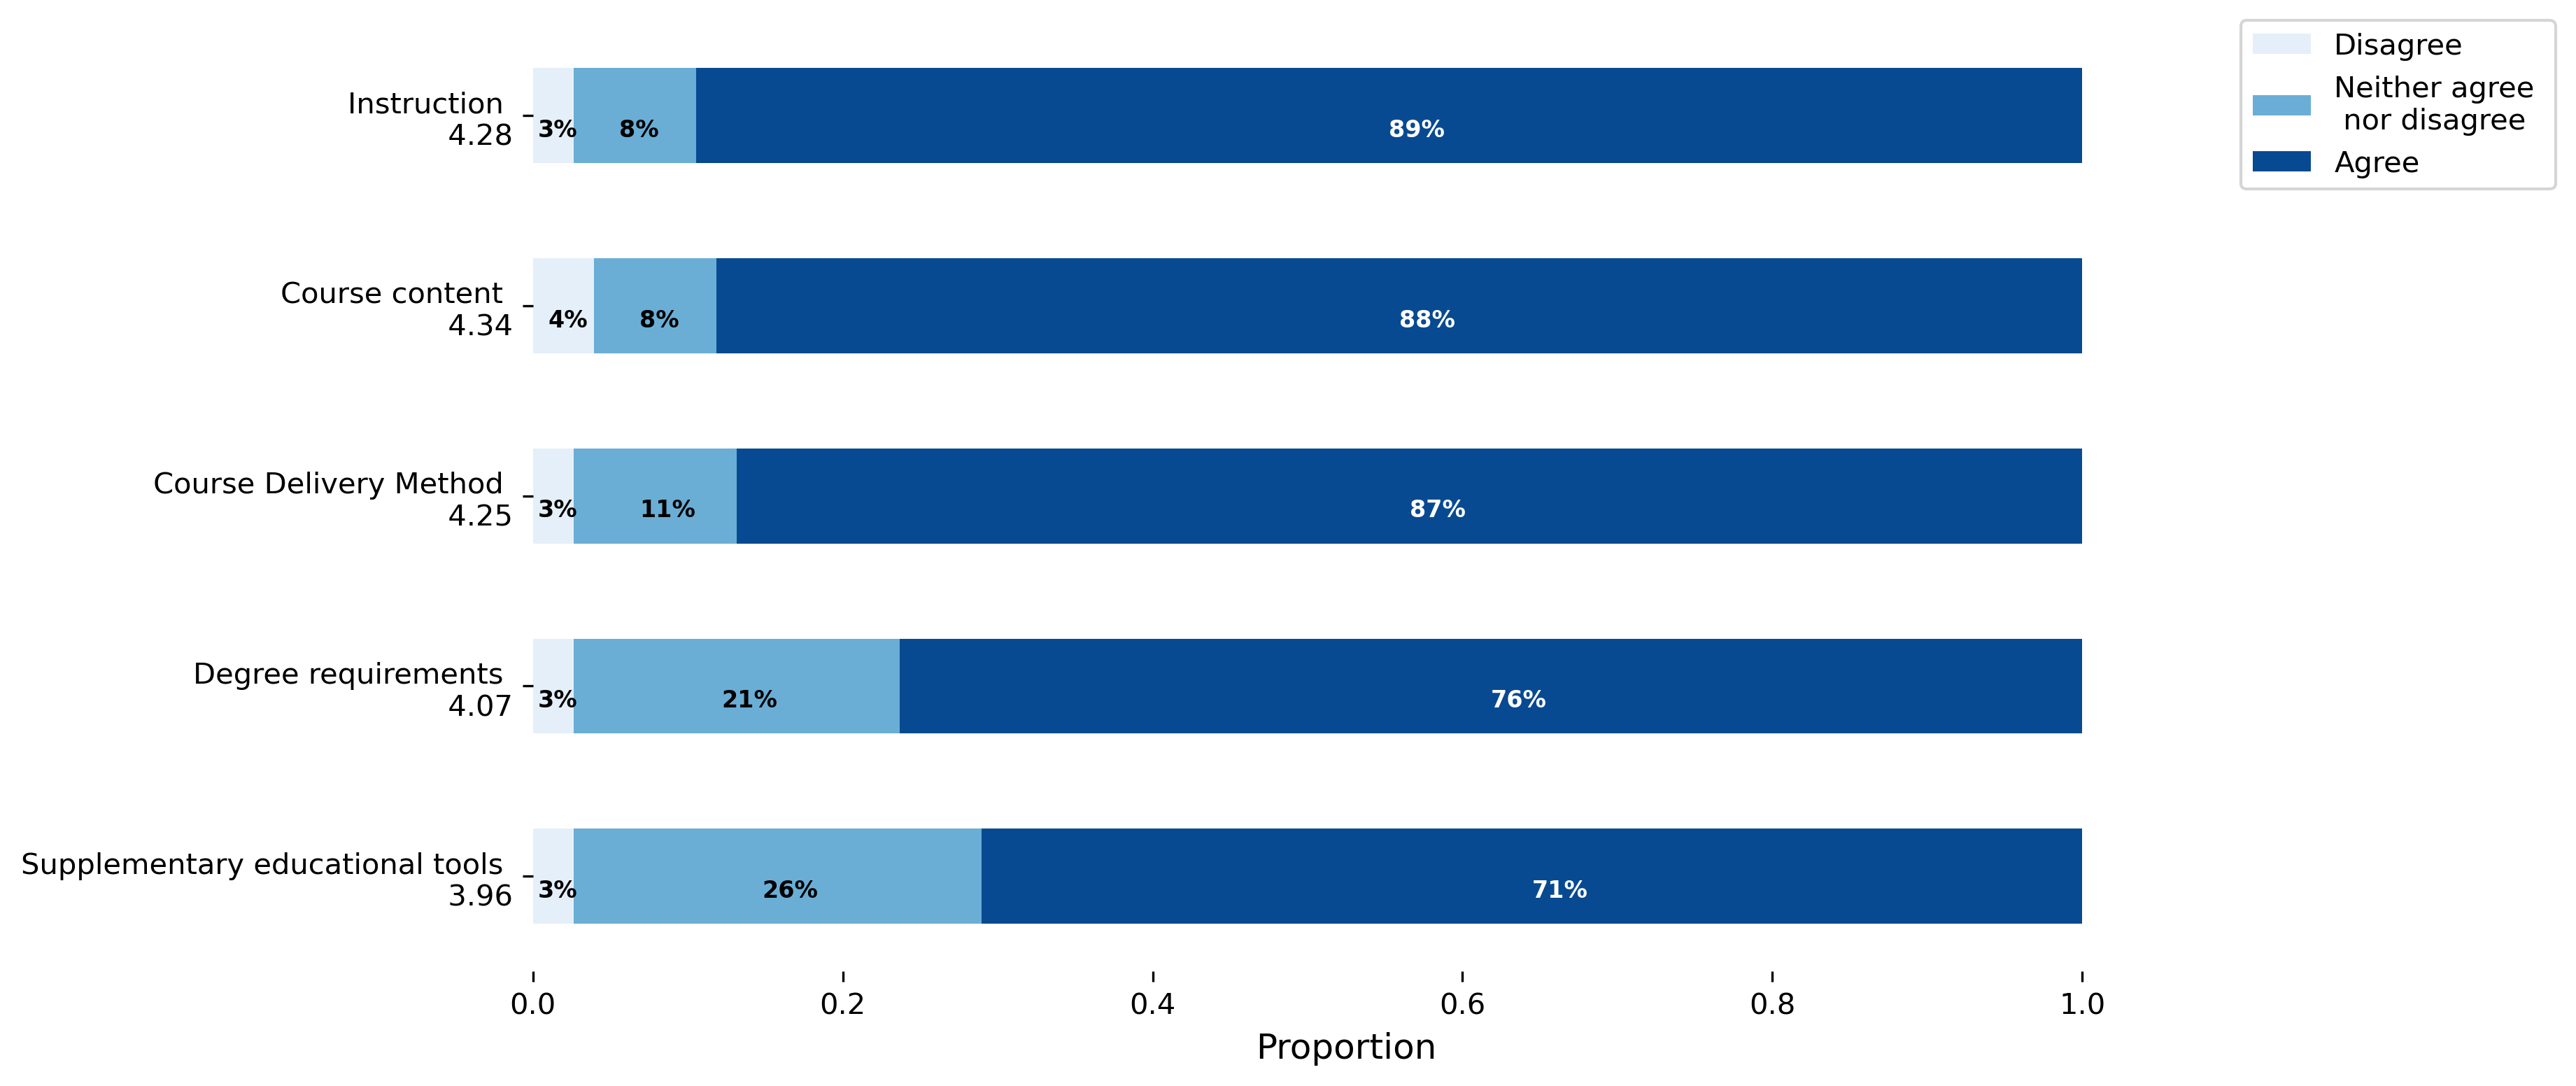

<AxesSubplot:xlabel='Proportion'>

In [131]:
aca_import_2022c.replace(2,1,inplace=True)
aca_import_2022c.replace(4,5,inplace=True)
aca_import_2022_count=aca_import_2022c.drop(columns = 'degree').apply(pd.value_counts,axis=0).sort_index()
aca_import_2022_count.columns = aca_import_2022_count.T.index+' \n '+acamean['mean'][aca_import_2022_count.T.index].astype(str) 
plot_3_cat(aca_import_2022_count)

In [104]:
aca=pd.DataFrame(aca_import_2022.mean(axis=0)[:5]).sort_values(0)[::-1]
#aca.rename(columns={0:'2022'},inplace=True)
#aca['2022']=(aca_import_2022.mean(axis=0)[:4])
aca.rename(index={'Supplementary educational tools':'Supplementary \n educational tools','Course Delivery Method':'Course \n Delivery Method'},inplace=True)



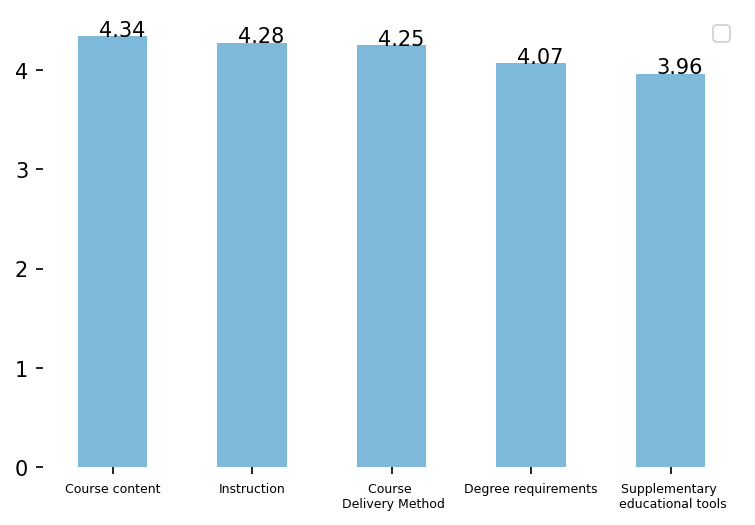

In [105]:
cmap = mpl.cm.Blues(np.linspace(0.4,0.9,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])
fig,ax=plt.subplots(figsize=(6,4),dpi=150)

aca.plot(kind='bar',colormap=cmap,ax=ax)

#plt.ylabel("Level of Satisfaction",fontsize=12)
#plt.xlabel("Academics Features",fontsize=10)
#plt.title("Student Satisfaction for Academics of MECE",fontsize=20)
plt.xticks(rotation=0,fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend('')
x_offset = -0.1
y_offset = 0.0
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2+ x_offset, b.y1+y_offset),fontsize=10)




In [106]:
acamean = (pd.DataFrame(aca_import_2022.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])

In [107]:
acamean

,mean
Course content,4.34
Instruction,4.28
Course Delivery Method,4.25
Degree requirements,4.07
Supplementary educational tools,3.96


In [56]:
aca

,0
Course content,4.315789
Instruction,4.294737
Course \n Delivery Method,4.157895
Degree requirements,4.063158
Supplementary \n educational tools,3.989474


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_15751/2367304371.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aca_import_2022['degree']=degree


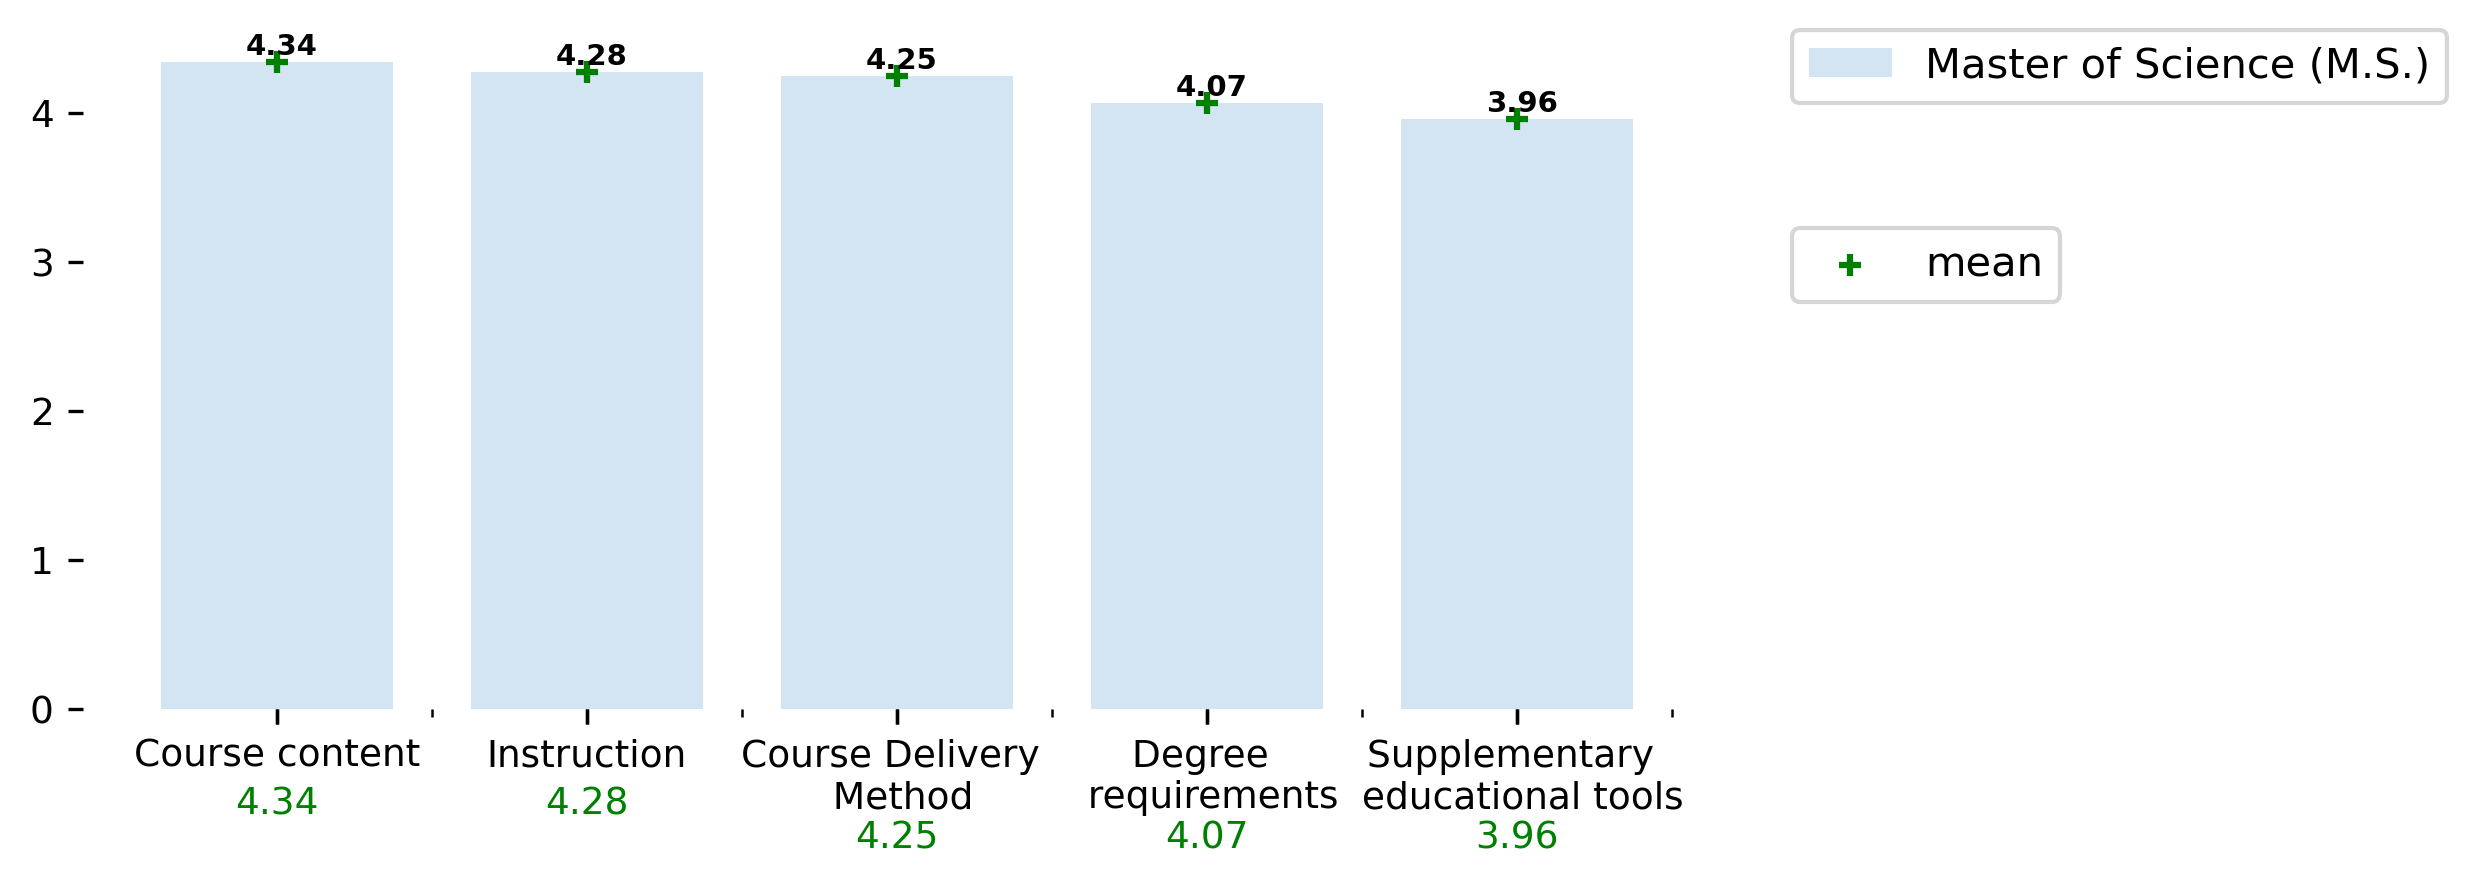

In [110]:
cmapr = mpl.cm.Blues(np.linspace(0,0.65,100))
cmapr = mpl.colors.ListedColormap(cmapr[10:,:-1])

cmap2 = mpl.cm.Blues(np.linspace(0.1,0.9,100))
cmap2 = mpl.colors.ListedColormap(cmap2[10:,:-1])
fig,ax=plt.subplots(figsize=(7,3),dpi=300)

df=aca_import_2022.groupby(['degree']).mean()#.drop(index='Professional Degree')
df=df[df.sum().sort_values().index[::-1]]

df.rename(columns={'Supplementary educational tools':'Supplementary \n educational tools',
                   'Degree requirements':'Degree \n requirements',
                   'Course Delivery Method':'Course Delivery \n Method'},inplace=True)
a = []
for i in list(zip(df.T.index,acamean['mean'].astype(str))):
    a.append(list(i))
xlbls = list(np.concatenate(a).flat)
dft = df.T
dft.index = df.T.index#+' \n '+acamean['mean'].astype(str) 
ax=dft.plot.bar(ax=ax,colormap=cmap2,width=0.75, rot=0 ,fontsize=9)

ax.set_xticks([0,0.0001,1,1.0001,2,2.0001,3,3.0001,4,4.0001])
ax.set_xticks([0.5,1.5,2.5,3.5,4.5], minor=True )
ax.set_xticklabels( xlbls )
# vertical alignment of xtick labels
va = [ 0, -.07, 0, -.07, 0, -.12, 0, -.12, 0, -.12, ]
for t, y in zip( ax.get_xticklabels( ), va ):
    t.set_y( y )

for i in [1,3,5,7,9]:
    plt.gca().get_xticklabels()[i].set_color("green")

x_offset = -0.1
y_offset = 0.05
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2+ x_offset, b.y1+y_offset),fontsize=7,fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for i in range(5):
    tri = ax.scatter(i,aca.iloc[i,0],s=30,marker='+',c='green')

leg1=plt.legend(handles=[tri], labels=['mean'],loc=(1.05,0.6))
ax.add_artist(leg1)



plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

In [61]:
resources_sat=query_data(Q,qq,df2022_ME,"satisfied",indx=6).copy()
resources_sat.replace('Unaware of this resource',0,inplace=True)

resources_sat['degree']=degree

I am satisfied with the following resources with respect to guidance in my degree program.


In [62]:
satmean = (pd.DataFrame(resources_sat.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])

/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_15751/851574871.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  satmean = (pd.DataFrame(resources_sat.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_15751/3538622488.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  satmean = (pd.DataFrame(resources_sat.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])


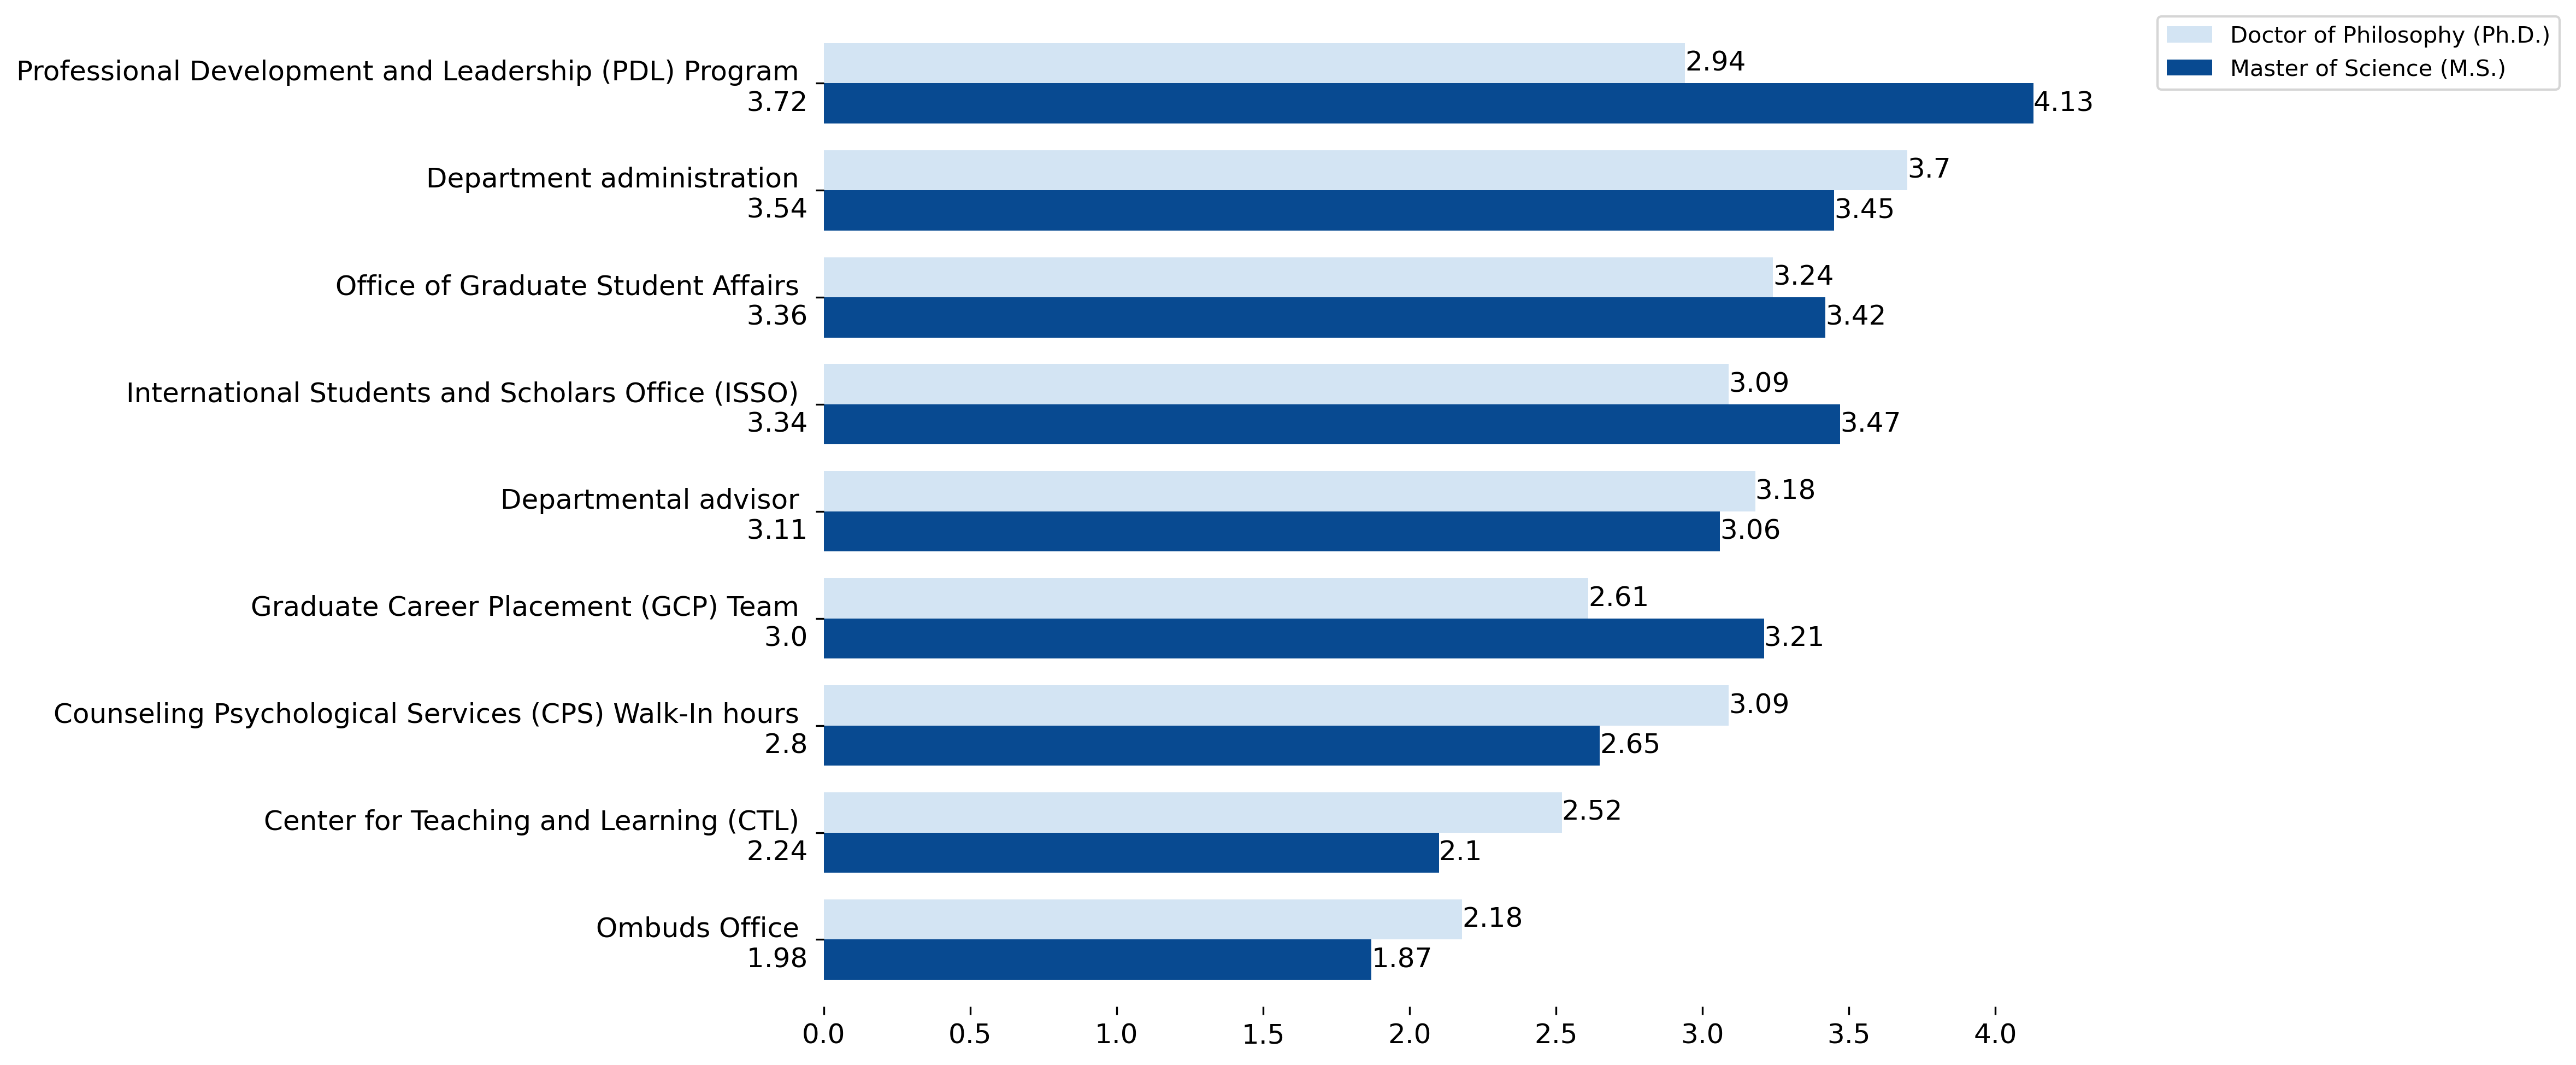

In [63]:
import matplotlib as mpl
cmap2 = mpl.cm.Blues(np.linspace(0.1,0.9,100))
cmap2 = mpl.colors.ListedColormap(cmap2[10:,:-1])
satmean = (pd.DataFrame(resources_sat.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])

fig,ax=plt.subplots(figsize=(10,8),dpi=300)
#aca_import['degree']=degree
df=resources_sat.groupby(['degree']).mean().round(2)#.drop(index='Professional Degree')
#df=df[df.mean().sort_values().index[::-1]]
df = df[['Professional Development and Leadership (PDL) Program','Department administration','Office of Graduate Student Affairs',
'International Students and Scholars Office (ISSO)',
'Departmental advisor',
'Graduate Career Placement (GCP) Team',
'Counseling Psychological Services (CPS) Walk-In hours',
'Center for Teaching and Learning (CTL)',
'Ombuds Office']]
dft = df.T
dft.index = df.T.index+' \n '+satmean['mean'].astype(str) 
ax=dft.plot.barh(ax=ax,colormap=cmap2,width=0.75, rot=0 ,fontsize=12)
#for i in range(12):
#ax.scatter(satmean.mean(),satmean.index(),s=90,marker='^')
#plt.vlines(x = satmean['mean'], ymin = np.arange(9)-0.2, ymax =np.arange(9)+0.2,colors = 'red')

#ax.set_xticklabels( rotation=0,)
x_offset = -0.1
y_offset = 0.05
for container in ax.containers:
    ax.bar_label(container,fontsize=12)
#for p in ax.patches:
 #   b = p.get_bbox()
  #  val = "{:.2f}".format(b.x1 + b.x0)        
  #  ax.annotate(val, (( b.y1)/2+ x_offset, b.x0 +b.x1+y_offset),fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.invert_yaxis()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

In [140]:
resources_sat=query_data(Q,qq,df2022_ME,"satisfied",indx=6).copy()
resources_sat.replace('Unaware of this resource',0,inplace=True)
res_satmean = (pd.DataFrame(resources_sat.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])
resources_sat.replace(2,1,inplace=True)
resources_sat.replace(4,5,inplace=True)
resources_sat_count=resources_sat.apply(pd.value_counts,axis=0)
resources_sat_count#.drop(index=0,inplace=True)

I am satisfied with the following resources with respect to guidance in my degree program.


,Ombuds Office,Department administration,Office of Graduate Student Affairs,Graduate Career Placement (GCP) Team,Departmental advisor,International Students and Scholars Office (ISSO),Professional Development and Leadership (PDL) Program,Center for Teaching and Learning (CTL),Counseling Psychological Services (CPS) Walk-In hours
0,38,14,15,10,11,12,1,35,27
1,2,10,4,11,6,5,8,1,6
3,16,10,15,11,10,13,8,15,15
5,20,42,42,44,49,46,59,25,28


In [141]:
resources_sat_count.columns = resources_sat_count.T.index+' \n '+res_satmean['mean'][resources_sat_count.T.index].astype(str) 

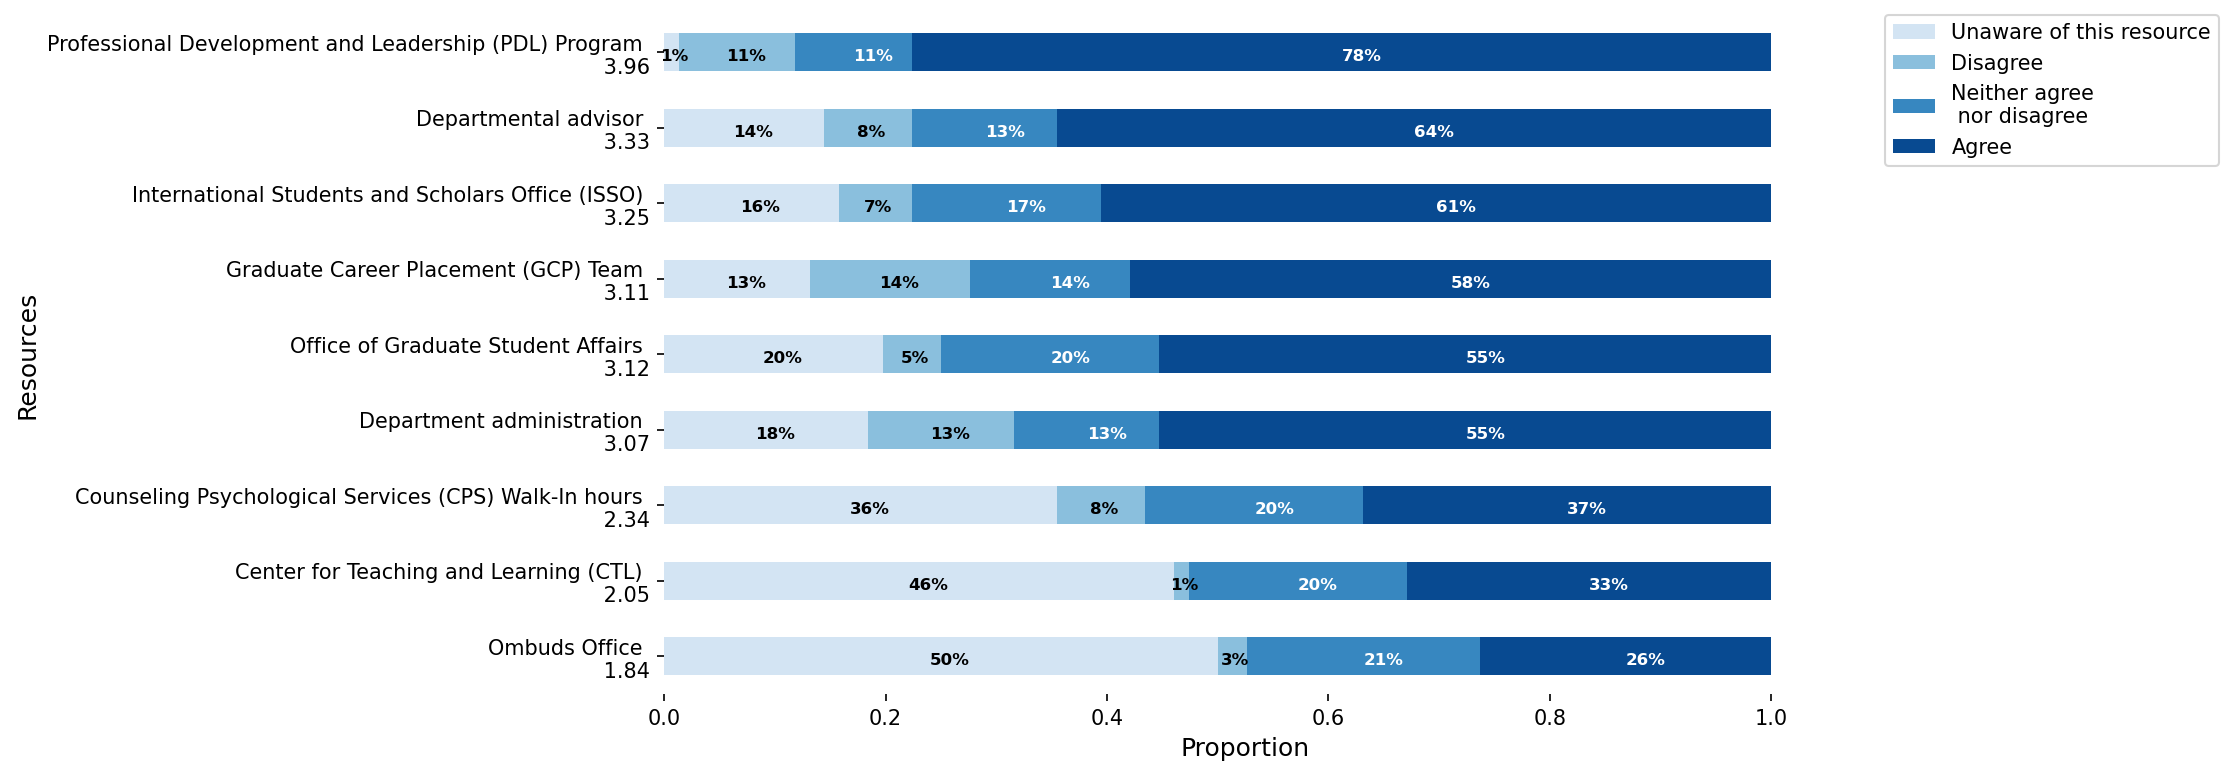

In [142]:
ind4=['Agree','Neither agree \n nor disagree','Disagree','Unaware of this resource']
import matplotlib as mpl
cmap2 = mpl.cm.Blues(np.linspace(0.1,0.9,100))
cmap2 = mpl.colors.ListedColormap(cmap2[10:,:-1])




b_prob=(resources_sat_count[(resources_sat_count.iloc[2:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
aaa=(b_prob[(b_prob.iloc[3:,:].sum()).sort_values().index]).T
bbb=b_prob[(b_prob.iloc[3:,:].sum()).sort_values().index].T

fig,ax=plt.subplots(figsize=(8,6),dpi=150)
bbb.plot(kind='barh', stacked=True,colormap=cmap2, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(ind4[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Resources",fontsize=12)
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=3
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<2:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=2:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

In [805]:
pd.DataFrame(df2022_ME.groupby(['degree','Department administration'])['Department administration'].count())[::-1]

Department administration
degree                       Department administration                           
Master of Science (M.S.)     Unaware of this resource                           4
                             5                                                 13
                             4                                                 25
                             3                                                 13
                             2                                                  3
                             1                                                  4
Doctor of Philosophy (Ph.D.) 5                                                  7
                             4                                                 16
                             3                                                  5
                             2                                                  3
                             1                                                  2

In [807]:
pd.DataFrame(df2022_ME.groupby(['degree','Departmental advisor'])['Departmental advisor'].count())[::-1]

Departmental advisor
degree                       Departmental advisor                          
Master of Science (M.S.)     Unaware of this resource                     5
                             5                                           11
                             4                                           20
                             3                                            9
                             2                                           11
                             1                                            6
Doctor of Philosophy (Ph.D.) Unaware of this resource                     4
                             5                                            3
                             4                                           16
                             3                                            7
                             2                                            2
                             1                                            1

In [804]:
pd.DataFrame(df2022_ME.groupby(['degree','Graduate Career Placement (GCP) Team'])['Graduate Career Placement (GCP) Team'].count())[::-1]

Graduate Career Placement (GCP) Team
degree                       Graduate Career Placement (GCP) Team                                      
Master of Science (M.S.)     Unaware of this resource                                                 6
                             5                                                                       14
                             4                                                                       19
                             3                                                                       11
                             2                                                                        8
                             1                                                                        4
Doctor of Philosophy (Ph.D.) Unaware of this resource                                                 8
                             5                                                                        2
                             4                                                                        9
                             3                                                                       12
                             2                                                                        2

### Teaching Quality

In [810]:

pd.DataFrame(df2022_ME.groupby(['degree','The overall teaching quality of the lecturer was satisfactory:'])['The overall teaching quality of the lecturer was satisfactory:'].count())[::-1]

The overall teaching quality of the lecturer was satisfactory:
degree                       The overall teaching quality of the lecturer wa...                                                                
Master of Science (M.S.)     Not Applicable                                                                                      1             
                             5                                                                                                  16             
                             4                                                                                                  35             
                             3                                                                                                   3             
                             2                                                                                                   5             
                             1                                                                                                   2             
Doctor of Philosophy (Ph.D.) Not Applicable                                                                                      1             
                             5                                                                                                  10             
                             4                                                                                                  17             
                             3                                                                                                   1             
                             2                                                                                                   3             
                             1                                                                                                   1

## Skill

In [146]:
skill=query_data(Q,qq,df2022_ME,"skills",indx=1).copy()
skillmean = (pd.DataFrame(skill.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])


skill.replace(2,1,inplace=True)
skill.replace(4,5,inplace=True)
skill_count=skill.apply(pd.value_counts,axis=0).sort_index()
skill_count

The following skills have been improved/enhanced by my time at Columbia SEAS.


,Presentation skills,Non-technical writing skills,Technical writing skills,Time management,Proficiency and expertise in my field,Working in a team,Interacting with Industry professionals,Leadership skills,Facilitating conversations and discussions,Keeping up with latest advances in my field
1,14,15,9,10,4,8,11,11,10,7
3,20,25,15,14,7,15,15,20,15,17
5,42,36,52,52,65,53,50,45,51,52


In [147]:
skill_count.columns = skill_count.T.index+' \n '+skillmean['mean'][skill_count.T.index].astype(str) 

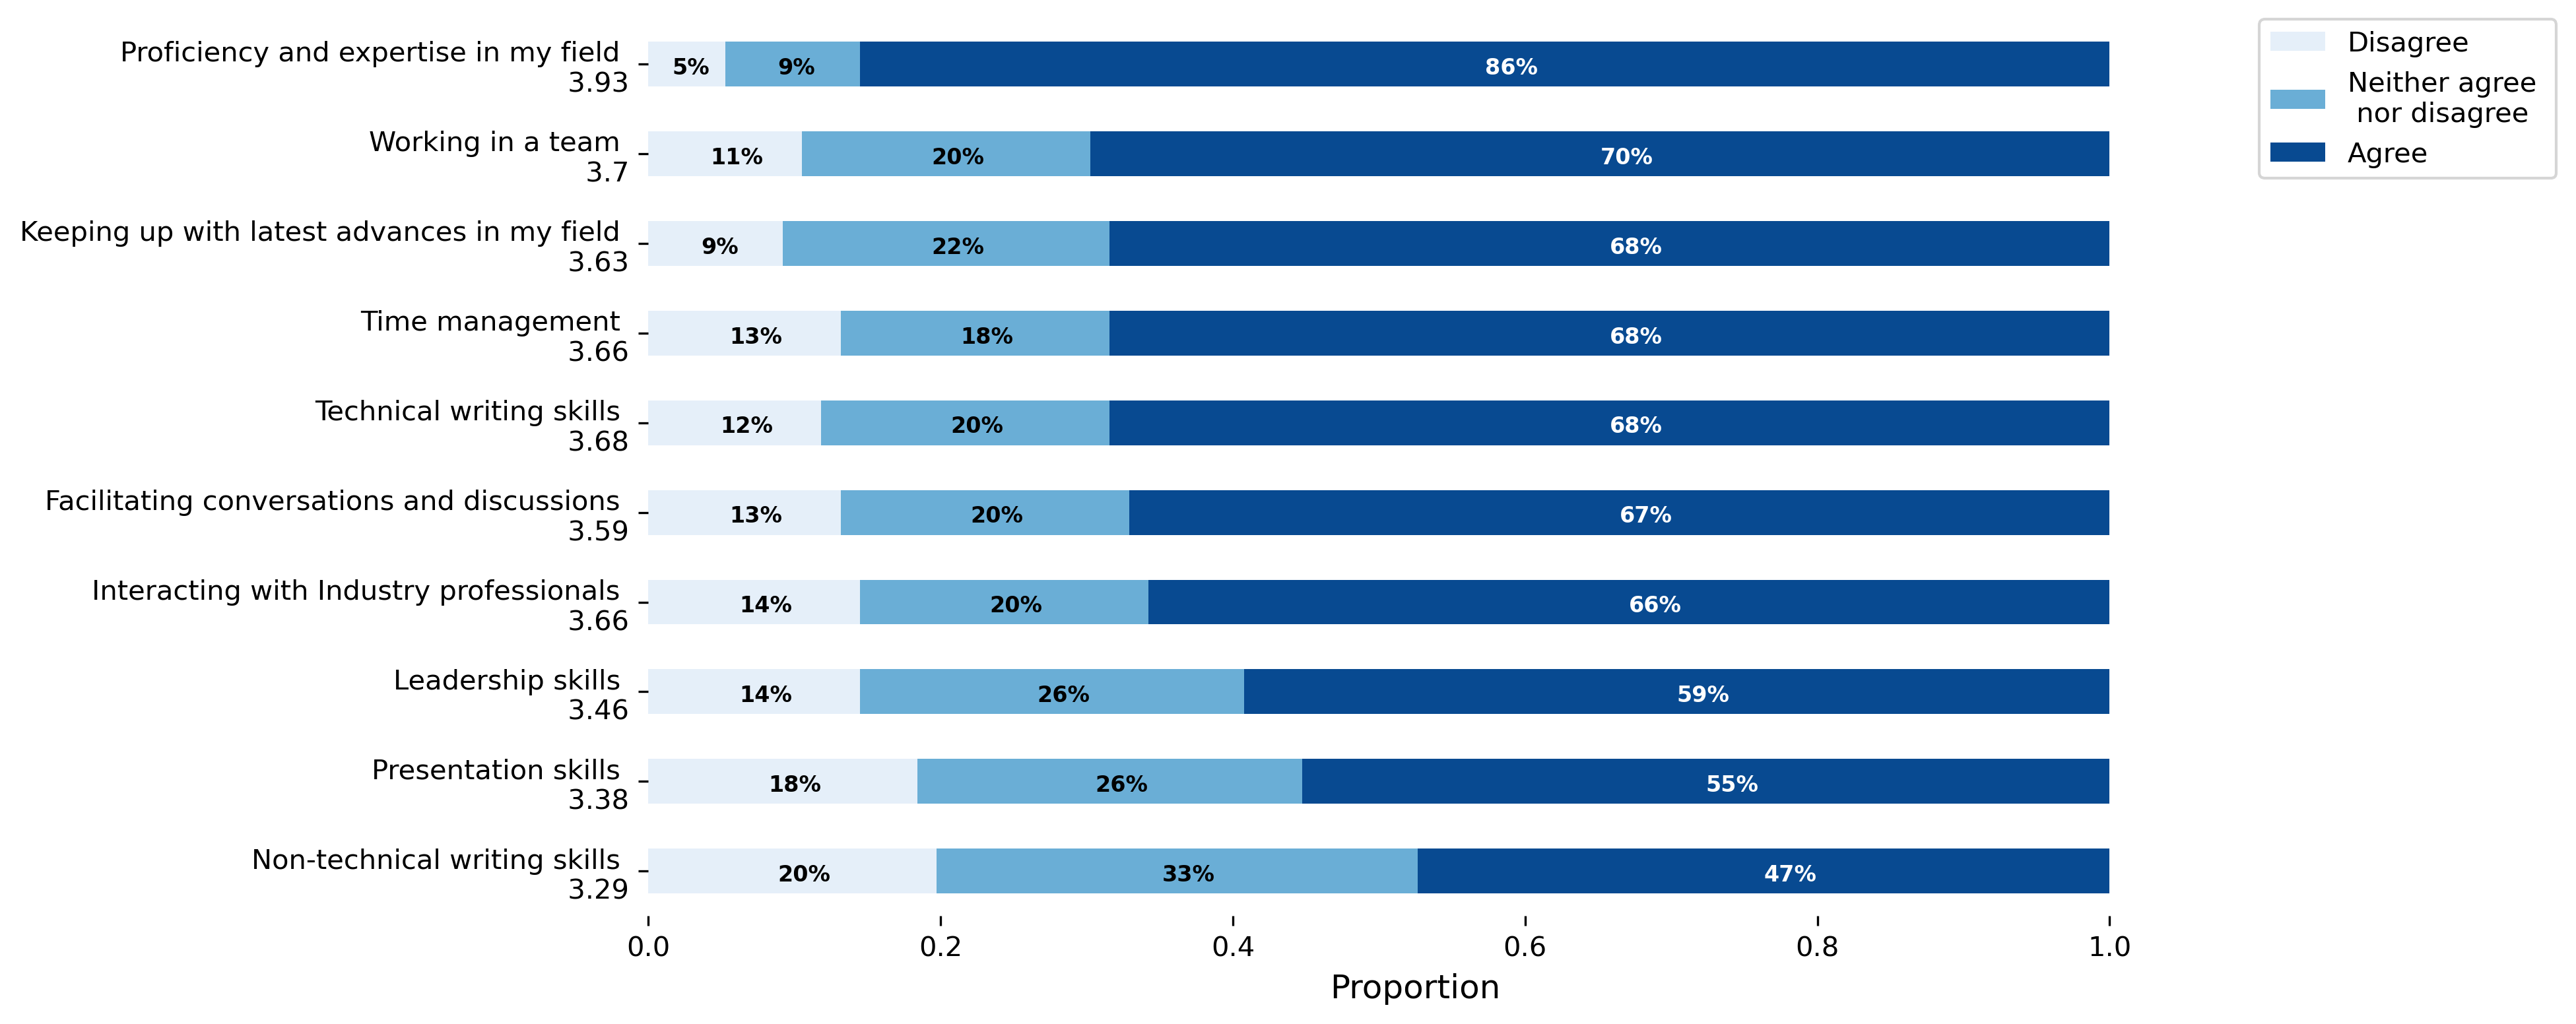

<AxesSubplot:xlabel='Proportion'>

In [148]:
plot_3_cat(skill_count)

In [811]:
skill['degree']=degree

In [812]:
skillmean = (pd.DataFrame(skill.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])

/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_61223/1248441492.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skillmean = (pd.DataFrame(skill.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])


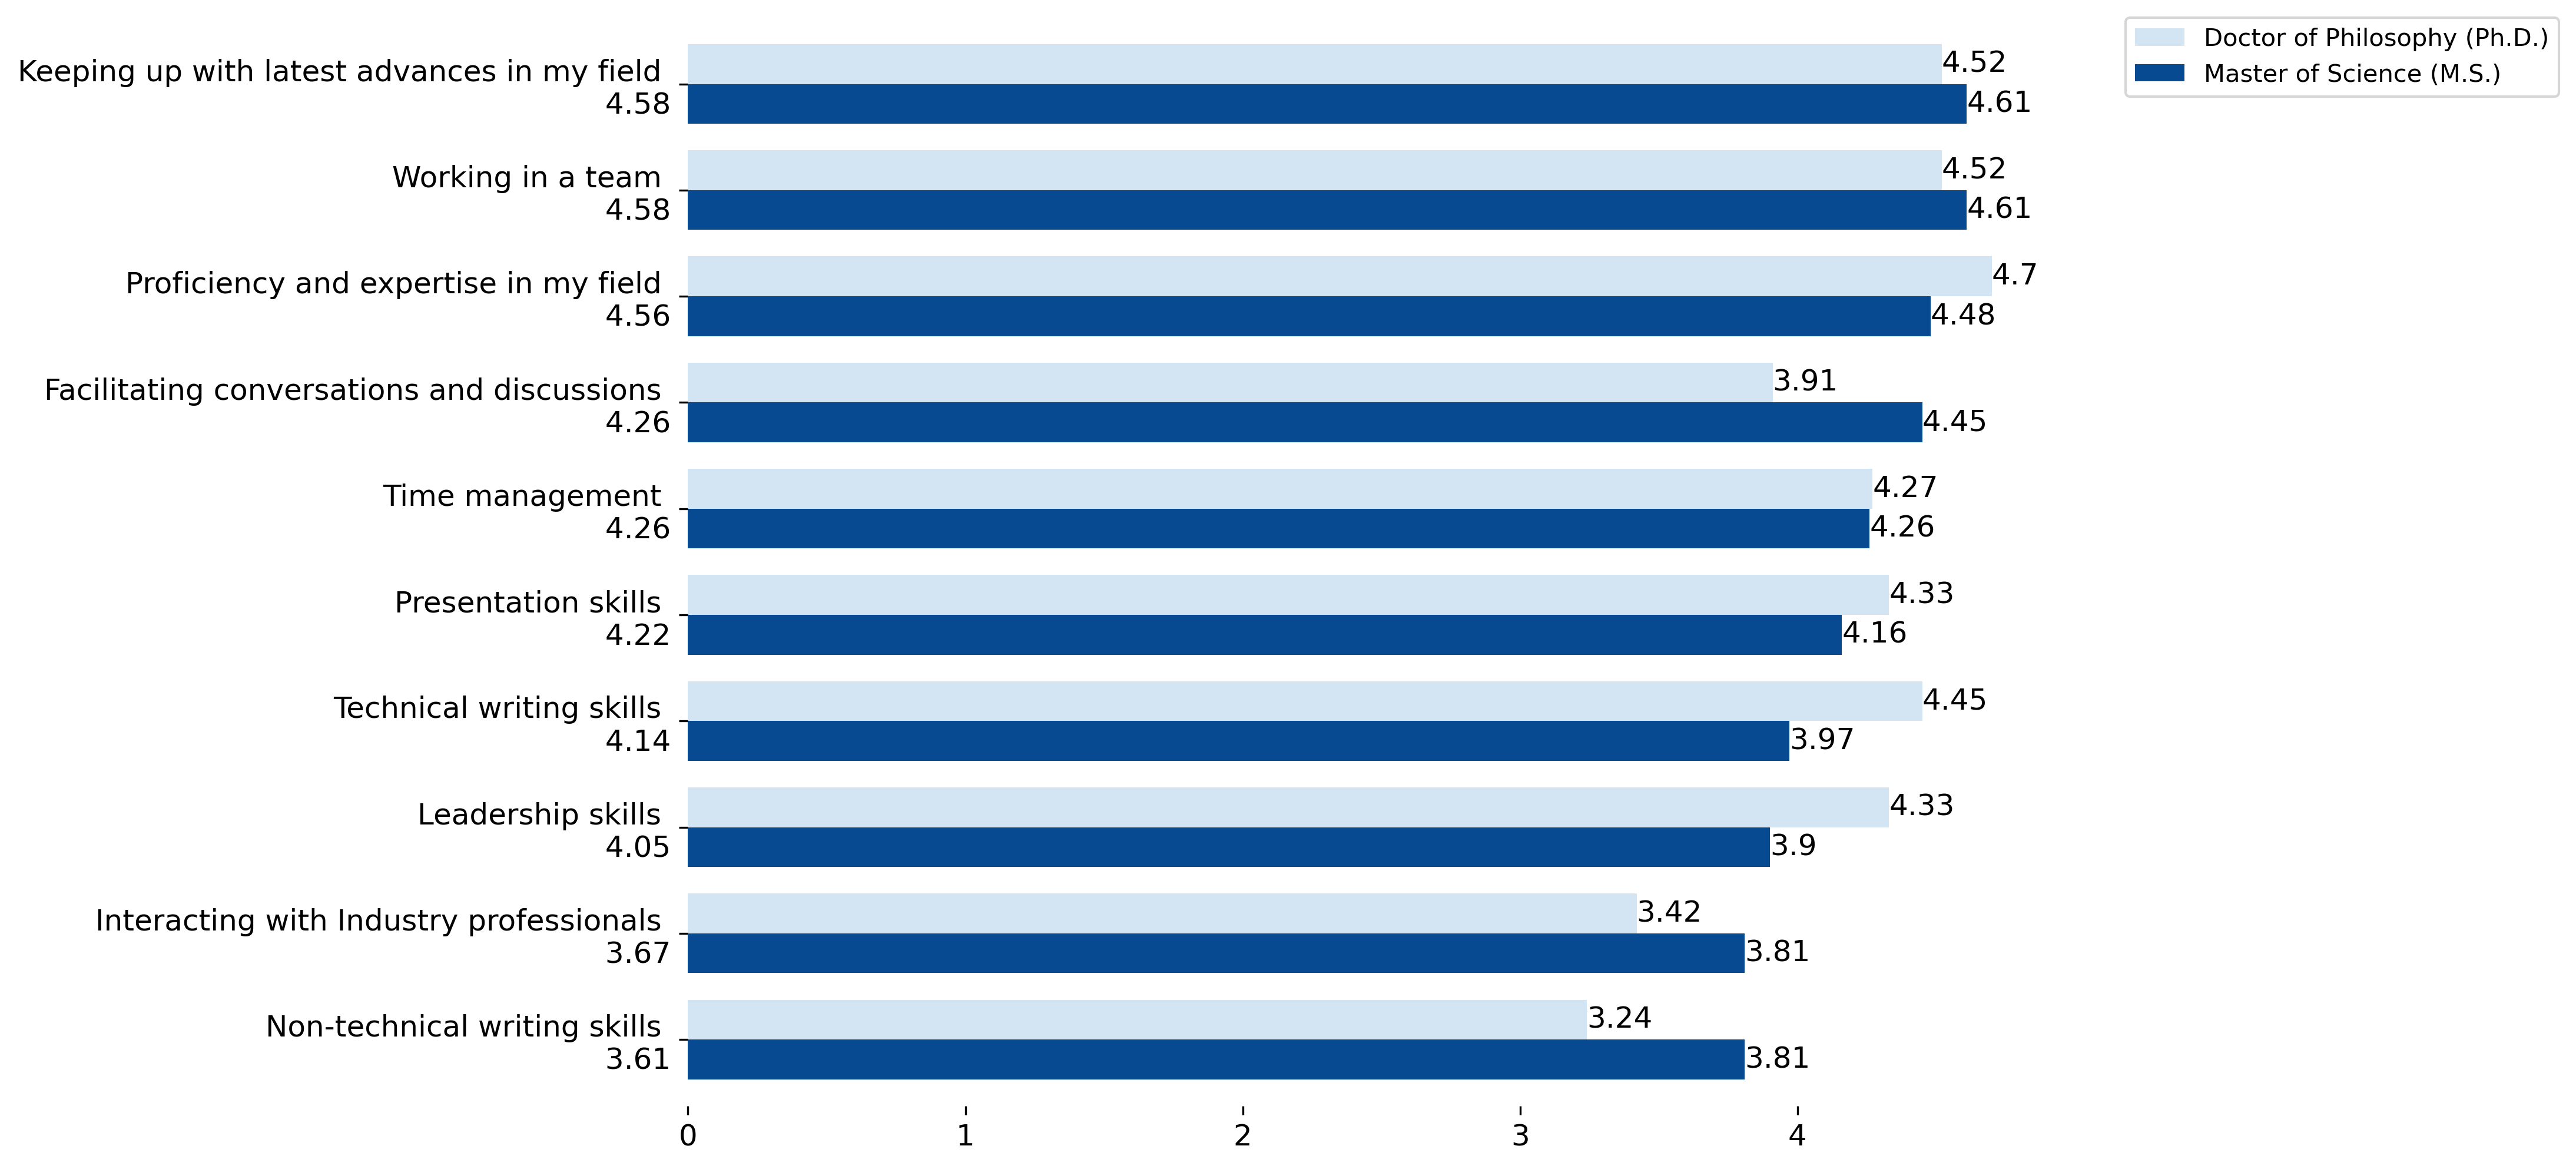

In [817]:

import matplotlib as mpl
#mpl.style.use('classic')
cmap2 = mpl.cm.Blues(np.linspace(0.1,0.9,100))
cmap2 = mpl.colors.ListedColormap(cmap2[10:,:-1])
plt.rcParams.update(plt.rcParamsDefault)

fig,ax=plt.subplots(figsize=(10,8),dpi=300)
#aca_import['degree']=degree
df=skill.groupby(['degree']).mean().round(2)#.drop(index='Professional Degree')
#df=df[df.mean().sort_values().index[::-1]]
df = df[skillmean.index]
dft = df.T
dft.index = df.T.index+' \n '+skillmean['mean'].astype(str) 
ax=dft.plot.barh(ax=ax,colormap=cmap2,width=0.75, rot=0 ,fontsize=12)
#for i in range(12):
#ax.scatter(satmean.mean(),satmean.index(),s=90,marker='^')
#plt.vlines(x = satmean['mean'], ymin = np.arange(9)-0.2, ymax =np.arange(9)+0.2,colors = 'red')

#ax.set_xticklabels( rotation=0,)
x_offset = -0.1
y_offset = 0.05
for container in ax.containers:
    ax.bar_label(container,fontsize=12)
#for p in ax.patches:
 #   b = p.get_bbox()
  #  val = "{:.2f}".format(b.x1 + b.x0)        
  #  ax.annotate(val, (( b.y1)/2+ x_offset, b.x0 +b.x1+y_offset),fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.invert_yaxis()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

## Job

In [155]:
lookingforjob=query_data(Q,qq,df2022_ME,"looking for a job",indx=1).copy()
lookingforjob.value_counts()
lookingforjob['degree']=degree

Are you currently looking for a job or plan to look for one in the near future?


In [156]:
lookingforjob.groupby(['degree']).value_counts()

degree                    Response.10
Master of Science (M.S.)  Yes            62
                          No             12
                          Not Sure        2
dtype: int64

In [173]:
jobres=query_data(Q,qq,df2022_ME,"job search",indx=1).copy()
lookingforjob=query_data(Q,qq,df2022_ME,"looking for a job",indx=1).copy()
jobres['looking']=lookingforjob
jobres['degree']=degree
jobres=jobres[jobres['degree']=='Master of Science (M.S.)']#Doctor of Philosophy (Ph.D.)
jobres.drop(columns='degree',inplace=True)
lokres=jobres[jobres['looking']!="No"].drop(columns="looking")
lokres_count=lokres.apply(pd.value_counts,axis=0)

The following resources have been/were useful in aiding my job search:
Are you currently looking for a job or plan to look for one in the near future?


In [174]:

lokres_count.columns = lokres_count.T.index+' \n '+round(lokres.mean(),2)[lokres_count.T.index].astype(str) 

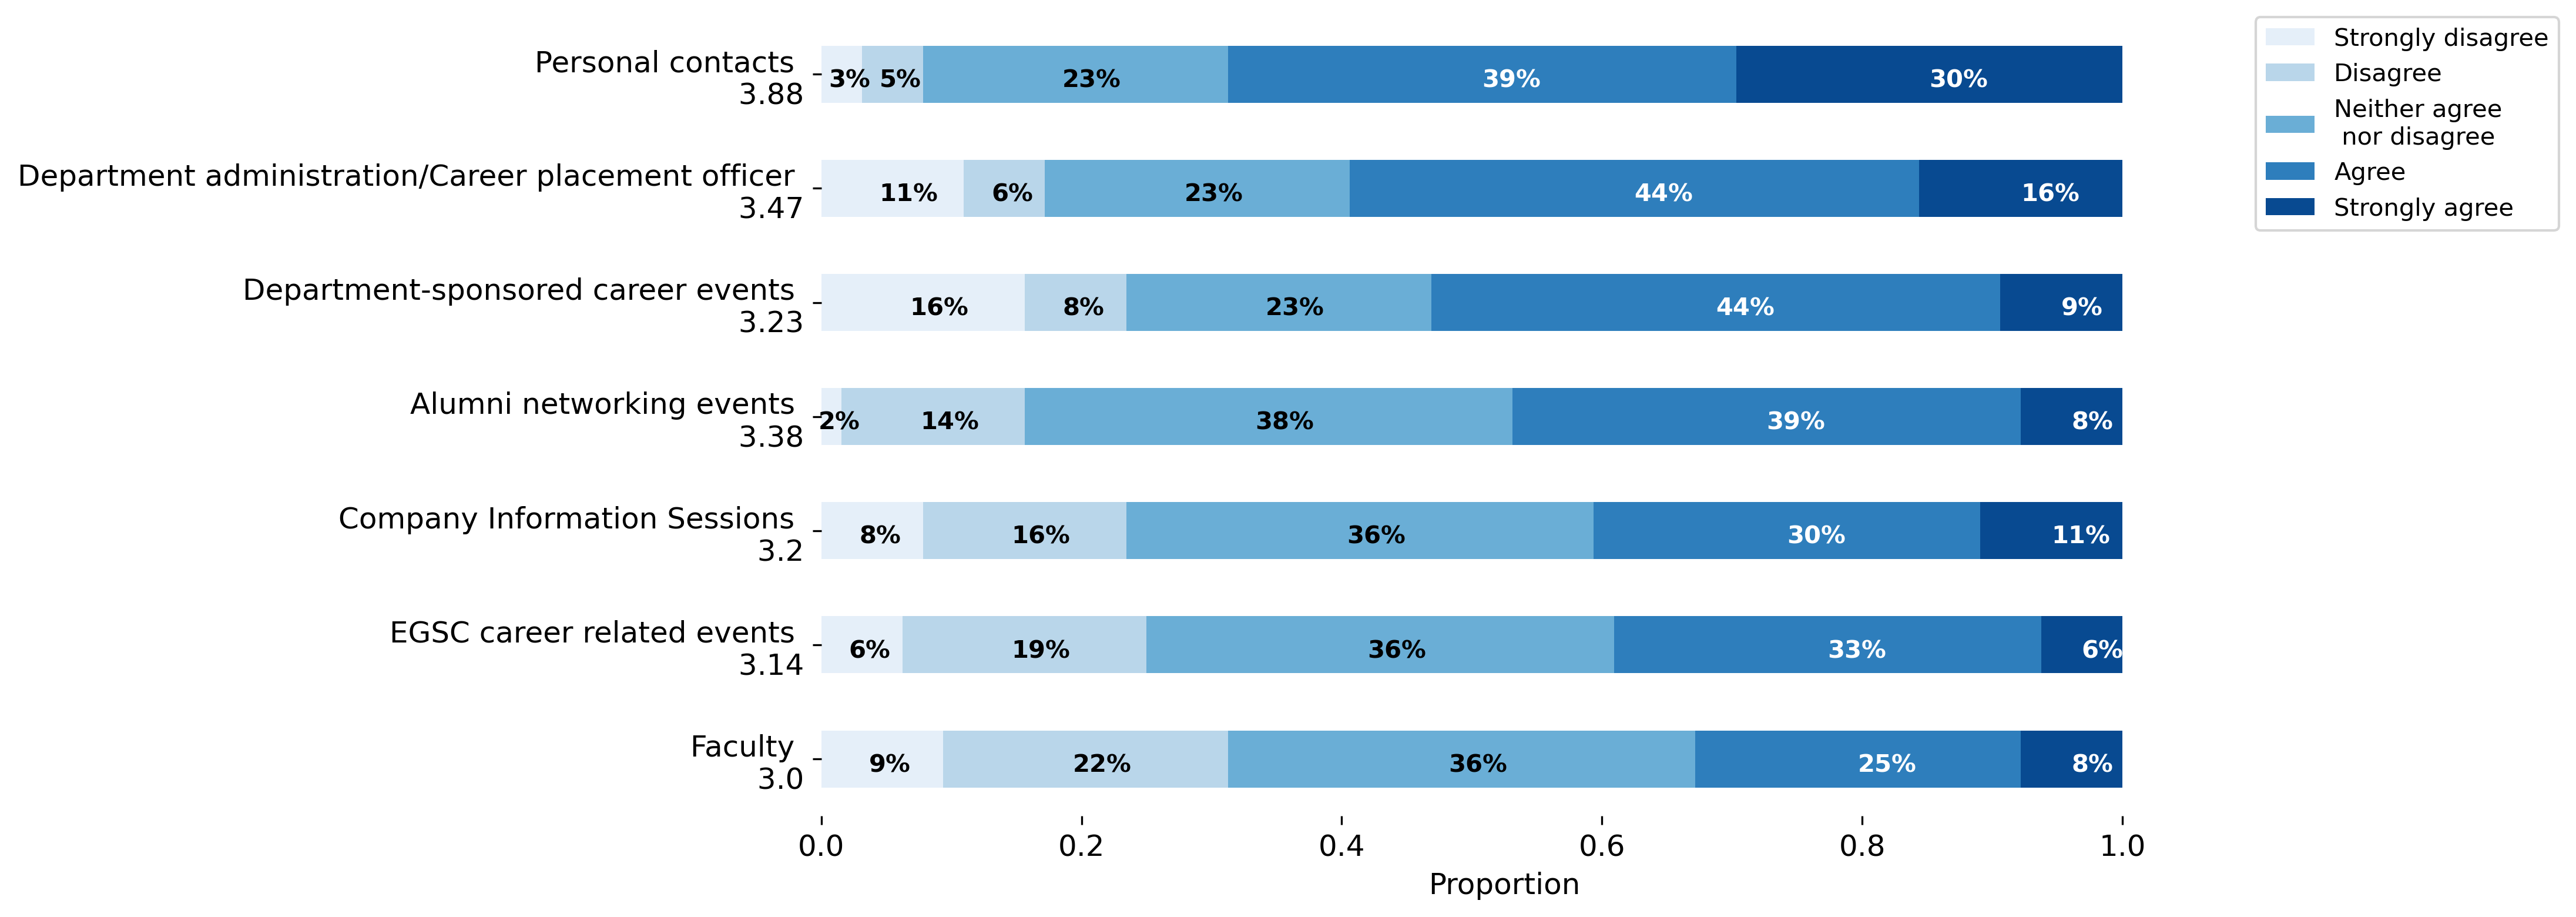

In [175]:

inddd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree','Unaware of this resource']


d_=lokres_count[(lokres_count.iloc[3:,:].sum()).sort_values().index]
b_prob=d_.apply(lambda x: x / x.sum(), axis=0)
aaa=d_.T
bbb=b_prob.T

cmap = mpl.cm.Blues(np.linspace(0,0.9,100)) #0.5
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])



fig,ax=plt.subplots(figsize=(6,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),fontsize=12,ax=ax)
#pd.DataFrame(b) 
plt.legend(inddd[:-1][::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="white",
                 fontsize=10,
                 fontweight="bold")
        if m>=3:
            if count>0:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="black",
                 fontsize=10,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

In [176]:
intern = query_data(Q,qq,df2022_ME,"internship",indx=1).copy()
intern['degree']=degree
intern.groupby(['degree']).value_counts()

Have you secured a job offer or internship?


degree                    Response.14                          
Master of Science (M.S.)  Yes                                      41
                          No                                       32
                          I am not actively searching for a job     3
dtype: int64

In [177]:
intern=76-query_data(Q,qq,df2022_ME,"secured",indx=2).isna().sum()

Which of the following have you secured?


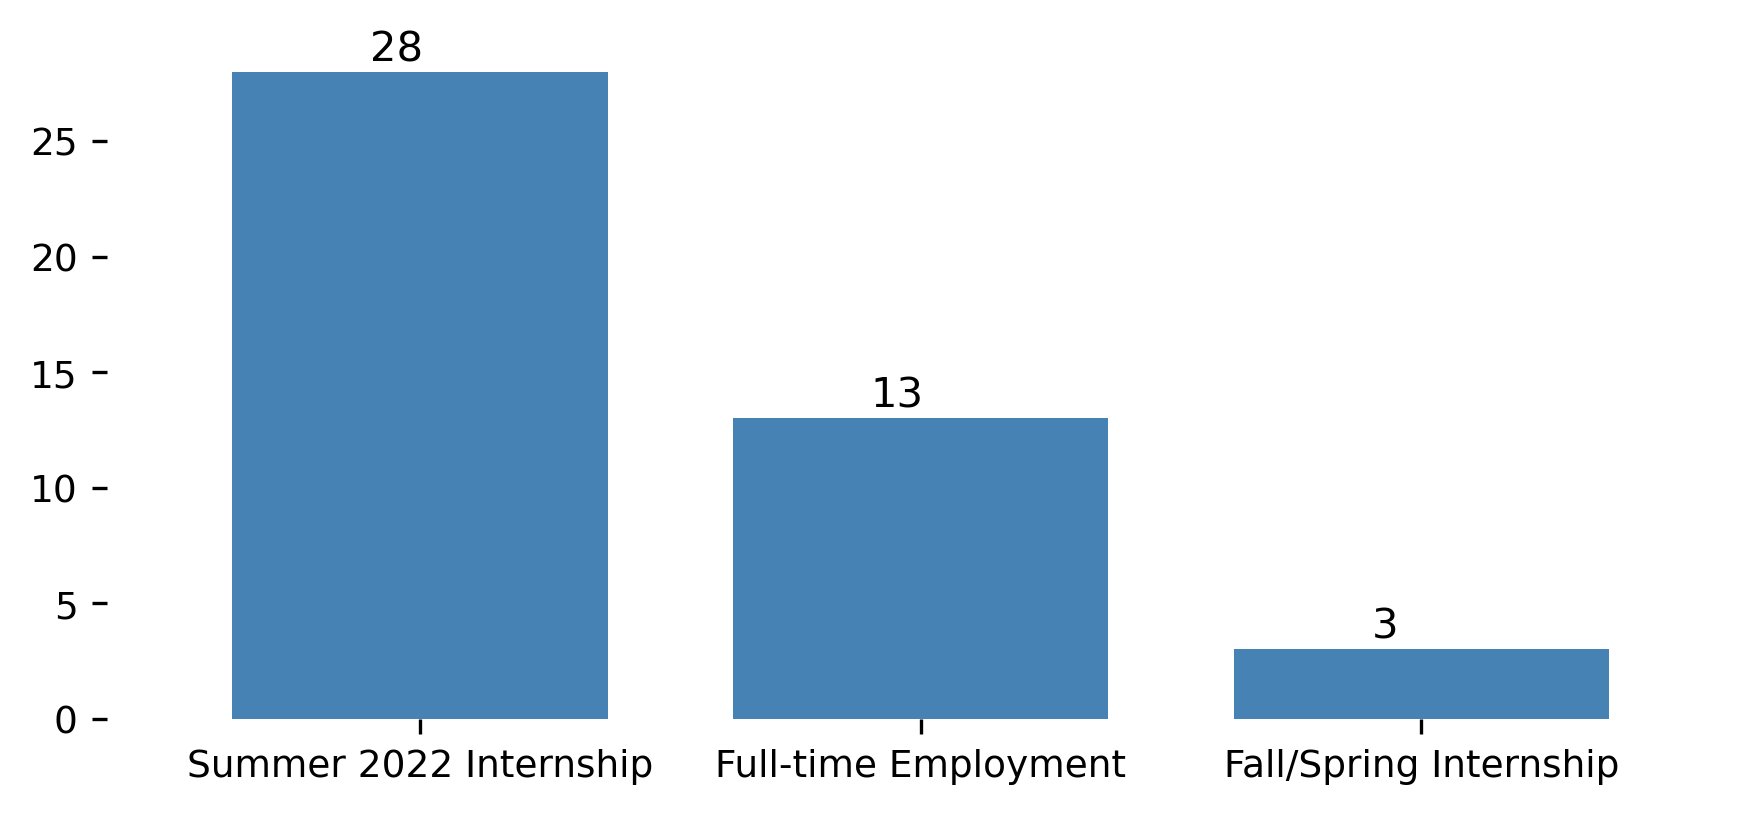

In [178]:
fig,ax=plt.subplots(figsize=(7,3),dpi=300)
intern=pd.DataFrame(intern)
ax=intern.plot.bar(ax=ax,color="steelblue",width=0.75, rot=0 ,fontsize=9,legend=None)
#ax.set_xticklabels(indd, rotation=0,)
x_offset = -0.1
y_offset = 0.5
for p in ax.patches:
    b = p.get_bbox()
    val = "{}".format(b.y1 + b.y0)        
    ax.annotate(int(b.y1 + b.y0), ((b.x0 + b.x1)/2+ x_offset, b.y1+y_offset),fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [180]:
pd.DataFrame(query_data(Q,qq,df2022_ME,"job opening",indx=1)['Response.15'].value_counts())

Where did you find out about this job opening?


,Response.15
Company website,12
LinkedIn,10
Personal contacts and/or friends,8
Other (please specify),4
Career fairs/Employer Expo Events,4
GCP (including VMock),2
Career Placement Officers,1


## Network

In [181]:
alu = query_data(Q,qq,df2022_ME,"alu",indx=1).copy()#.sum(axis=0)
pd.DataFrame(alu.apply(pd.value_counts,axis=0).sum())

Which of the following have you used to develop alumni contacts (check all that apply)?


,0
I have not been actively developing alumni contacts,21.0
"Alumni Associations (CEAA, CEYA, CAA)",5.0
Events organized by the Alumni Affairs Office,10.0
Events organized by EGSC or Office of Graduate Student Affairs,18.0
Faculty.1,8.0
Graduate Engineer's Connect,8.0
Department administration.1,18.0
Friends,49.0
"Events organized by student groups (CCV, CEEC, CFEC, DGE, DSISC, ELC, GEEC, GoBME, GradSWE, HinduYUVA, MEGA, PMC, qSTEM, SPICMACAY)",11.0
Professional Development and Leadership (PDL) Program.1,17.0


In [183]:
(alu.fillna(0).apply(pd.value_counts,axis=1)[0]>10).sum()

0

In [182]:
alu['Other (please specify).3'].value_counts()

LinkedIn                    2
DSI Alumni                  1
LinkedIn                    1
Linkedin and self search    1
Name: Other (please specify).3, dtype: int64

In [184]:
alum = query_data(Q,qq,df2022_ME,"alu",indx=2).copy()
alum['degree']=degree
pd.DataFrame(alum.groupby(['degree']).value_counts())

I am likely to return to Columbia as an alum to take part in online or in-person networking events.


0
degree                   Response.18    
Master of Science (M.S.) 4            35
                         5            23
                         3            14
                         1             2
                         2             2

In [185]:
query_data(Q,qq,df2022_ME,"alu",indx=3).copy().apply(pd.value_counts,axis=0)

Why would you not likely attend networking events as an alum?


,Response.19,Other (please specify).4
I don't find the current networking events appealing,4,NaN


In [186]:
query_data(Q,qq,df2022_ME,"alu",indx=4).copy().value_counts()

Please enter any additional feedback regarding alumni networking events.


Open-Ended Response.4                                                                                                           
1. Need to have more 1:1 sessions.                                                                                                  1
Alumini should speak the truth about their experience and talk about actual struggle they had during graduate studies               1
Alumni is one of the strongest points of Columbia  I received my job because of the alumni                                          1
I may reconsider coming back for alumni events in the future, but I will have to overcome a general distaste for the university.    1
It is helpful to have a breakout rooms so that students can have personalized one to one interactions                               1
More often it should be connected and industry specific                                                                             1
No comments                                                        

## EGSC GSA


I have enjoyed or would enjoy attending the following types of events sponsored or co-sponsored by EGSC or GSA:


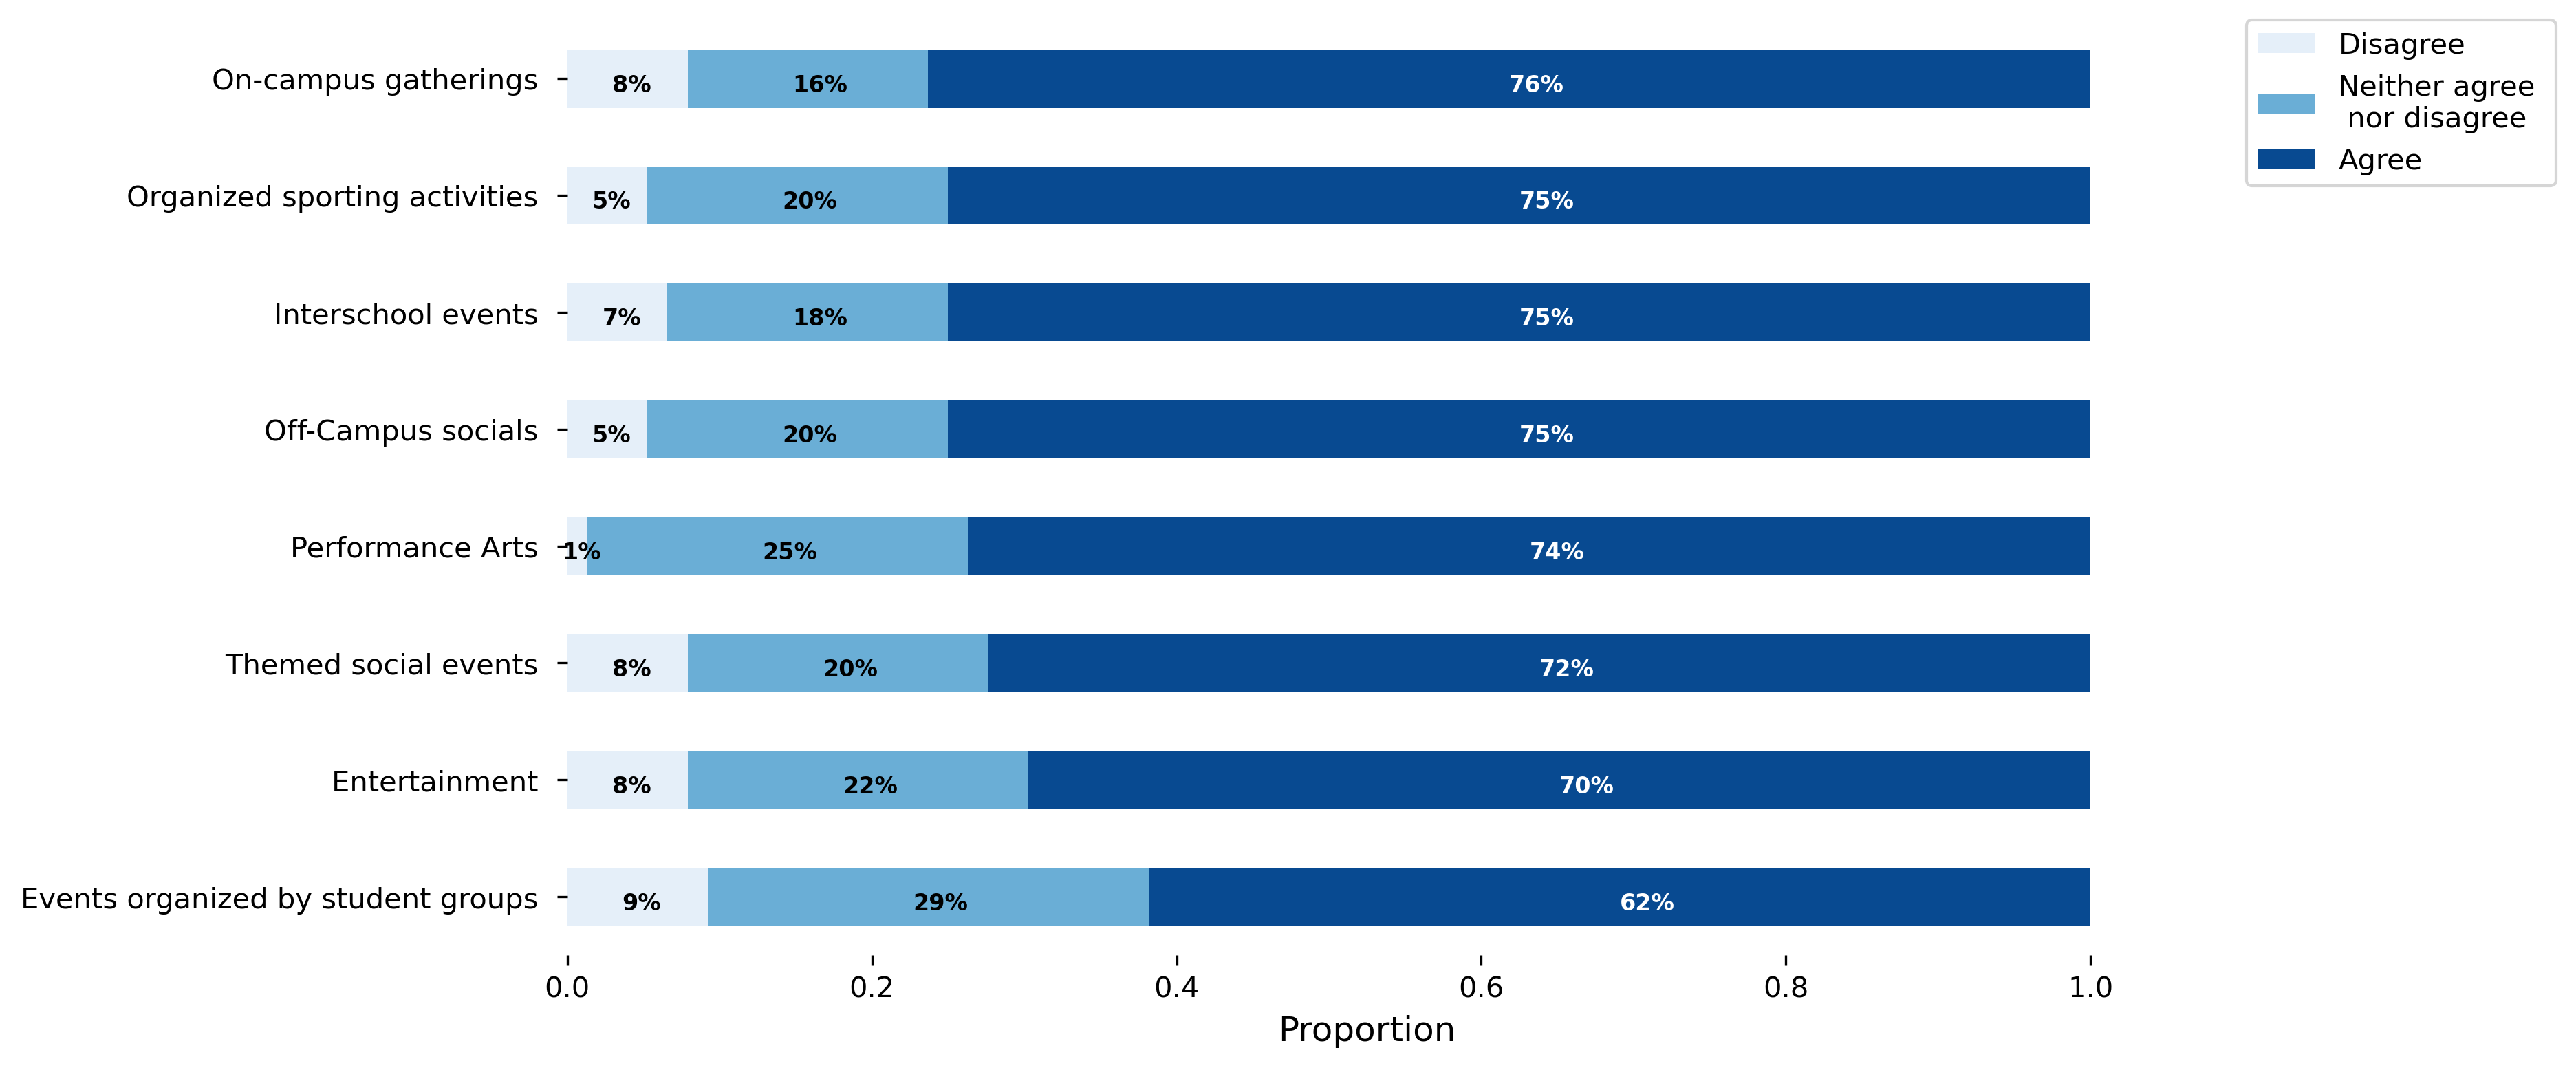

<AxesSubplot:xlabel='Proportion'>

In [187]:
egsc = query_data(Q,qq,df2022_ME,"EGSC",indx=1).copy()
#egsc.rename(columns={'Events organized by student groups (CCV, CEEC, CFEC, DGE, DSISC, ELC, GEEC, GoBME, GradSWE, HinduYUVA, MEGA, PMC, qSTEM, SPICMACAY).1':'Events organized by student groups (CCV, CEEC,etc.'},inplace=True)
egsc.columns = egsc.columns.str.split('(').str[0]
egsc.replace(2,1,inplace=True)
egsc.replace(4,5,inplace=True)
egsc_count=egsc.apply(pd.value_counts,axis=0).sort_index()
plot_3_cat(egsc_count)

In [188]:
egsc = query_data(Q,qq,df2022_ME,"EGSC",indx=1).copy()
egsc.columns = egsc.columns.str.split('(').str[0]
egsc['degree']=degree
egscmean = (pd.DataFrame(egsc.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])

I have enjoyed or would enjoy attending the following types of events sponsored or co-sponsored by EGSC or GSA:


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_15751/1832408087.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  egscmean = (pd.DataFrame(egsc.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])


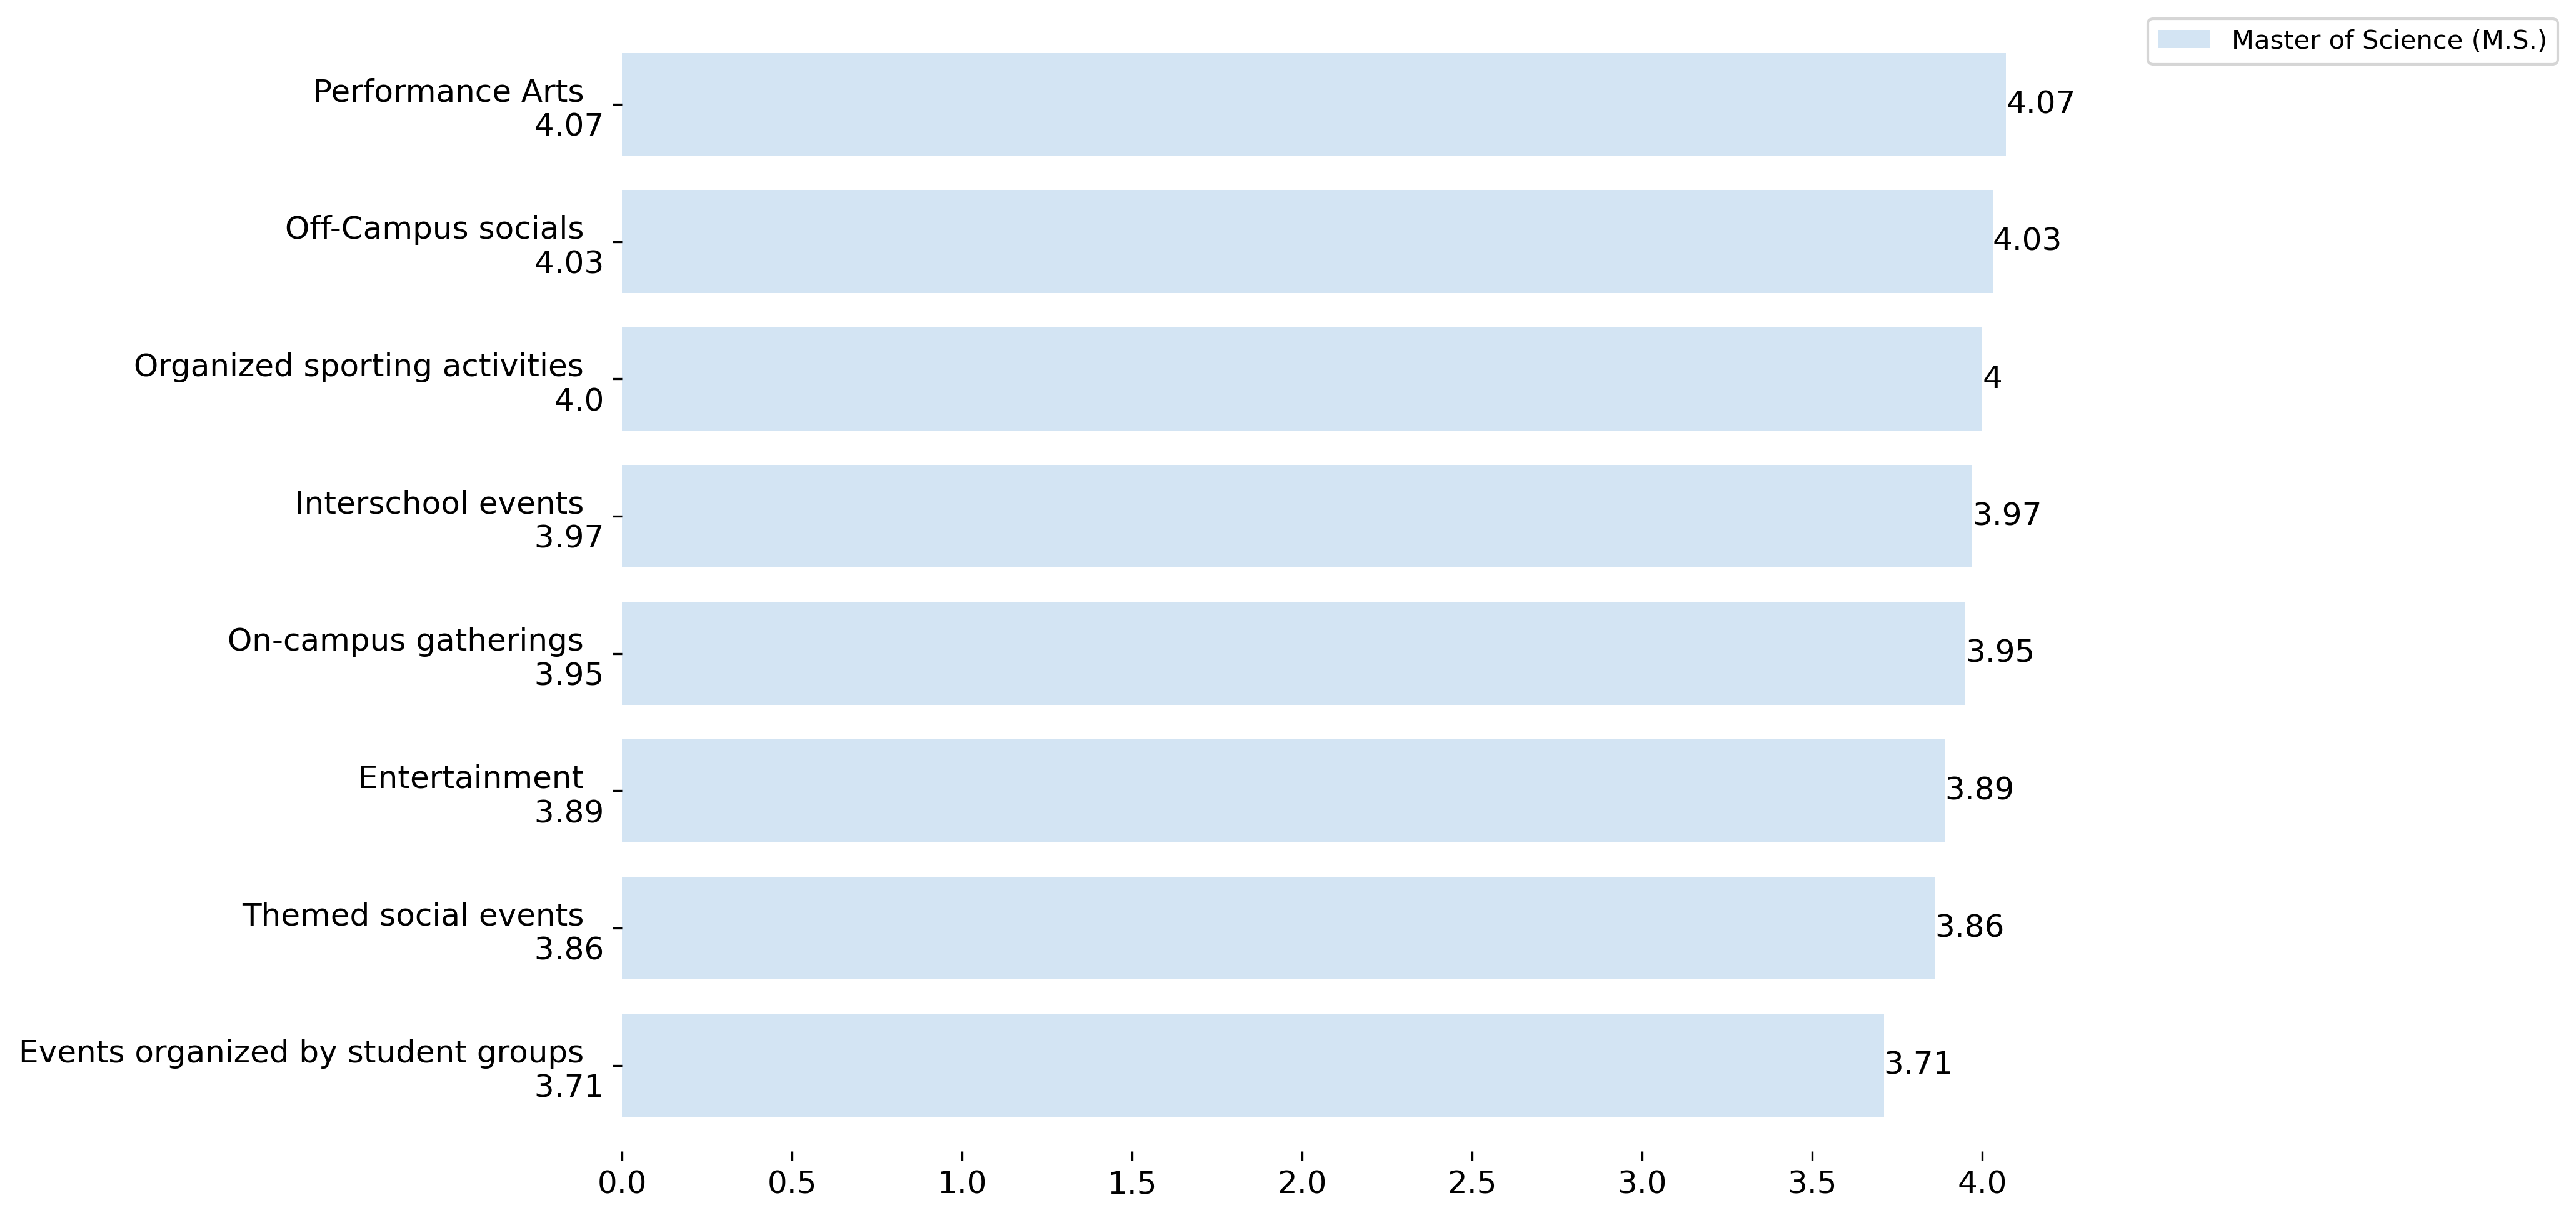

In [189]:
import matplotlib as mpl
cmap2 = mpl.cm.Blues(np.linspace(0.1,0.9,100))
cmap2 = mpl.colors.ListedColormap(cmap2[10:,:-1])


fig,ax=plt.subplots(figsize=(10,8),dpi=300)
#aca_import['degree']=degree
df=egsc.groupby(['degree']).mean().round(2)#.drop(index='Professional Degree')
#df=df[df.mean().sort_values().index[::-1]]
df = df[egscmean.index]
dft = df.T
dft.index = df.T.index+' \n '+egscmean['mean'].astype(str) 
ax=dft.plot.barh(ax=ax,colormap=cmap2,width=0.75, rot=0 ,fontsize=12)
#for i in range(12):
#ax.scatter(satmean.mean(),satmean.index(),s=90,marker='^')
#plt.vlines(x = satmean['mean'], ymin = np.arange(9)-0.2, ymax =np.arange(9)+0.2,colors = 'red')

#ax.set_xticklabels( rotation=0,)
x_offset = -0.1
y_offset = 0.05
for container in ax.containers:
    ax.bar_label(container,fontsize=12)
#for p in ax.patches:
 #   b = p.get_bbox()
  #  val = "{:.2f}".format(b.x1 + b.x0)        
  #  ax.annotate(val, (( b.y1)/2+ x_offset, b.x0 +b.x1+y_offset),fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.invert_yaxis()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

In [208]:
community = query_data(Q,qq,df2022_ME,'How satisfied are you with the following?',indx=1).copy()
community['degree'] = degree
community2019 = df2019_ME[community.columns].copy()
community2019['degree'] = degree

How satisfied are you with the following?


In [209]:
community.replace('Satisfied',4,inplace=True)
community.replace('Neither satisfied nor dissatisfied',3,inplace=True)
community.replace('Dissatisfied',2,inplace=True)
community.replace('Very satisfied',5,inplace=True)
community.replace('Very dissatisfied',1,inplace=True)
community2019.replace('Satisfied',4,inplace=True)
community2019.replace('Neither satisfied nor dissatisfied',3,inplace=True)
community2019.replace('Dissatisfied',2,inplace=True)
community2019.replace('Very satisfied',5,inplace=True)
community2019.replace('Very dissatisfied',1,inplace=True)

/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_15751/4258933214.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  commean = (pd.DataFrame(community.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])


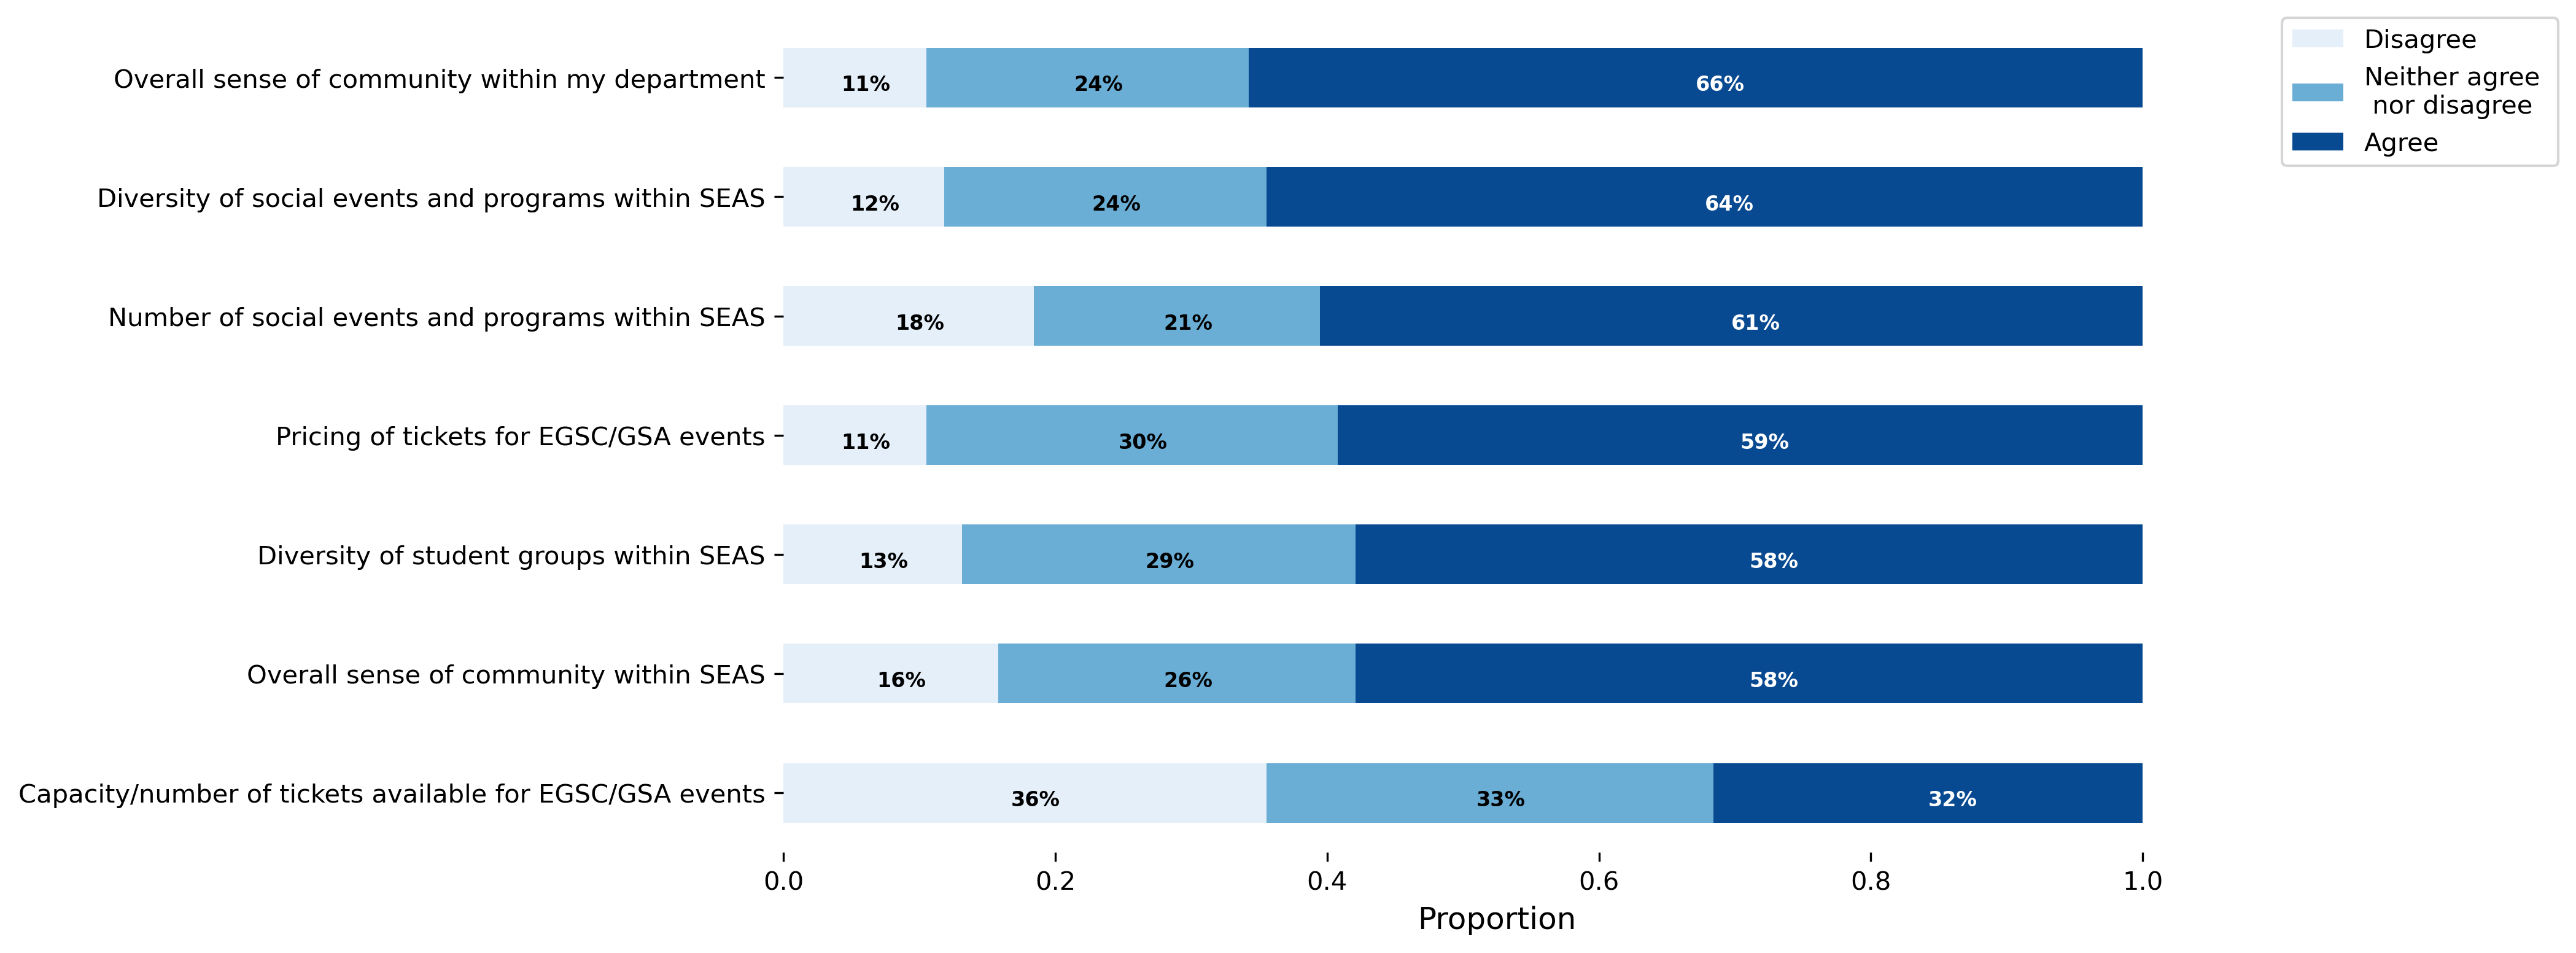

<AxesSubplot:xlabel='Proportion'>

In [211]:
commean = (pd.DataFrame(community.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])


community.replace(2,1,inplace=True)
community.replace(4,5,inplace=True)
community_count=community.drop(columns='degree').apply(pd.value_counts,axis=0).sort_index()
#community_count.columns = community_count.T.index+' \n '+commean['mean'][community_count.T.index].astype(str) 
plot_3_cat(community_count)


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_15751/1482250404.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  commean = (pd.DataFrame(community.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])


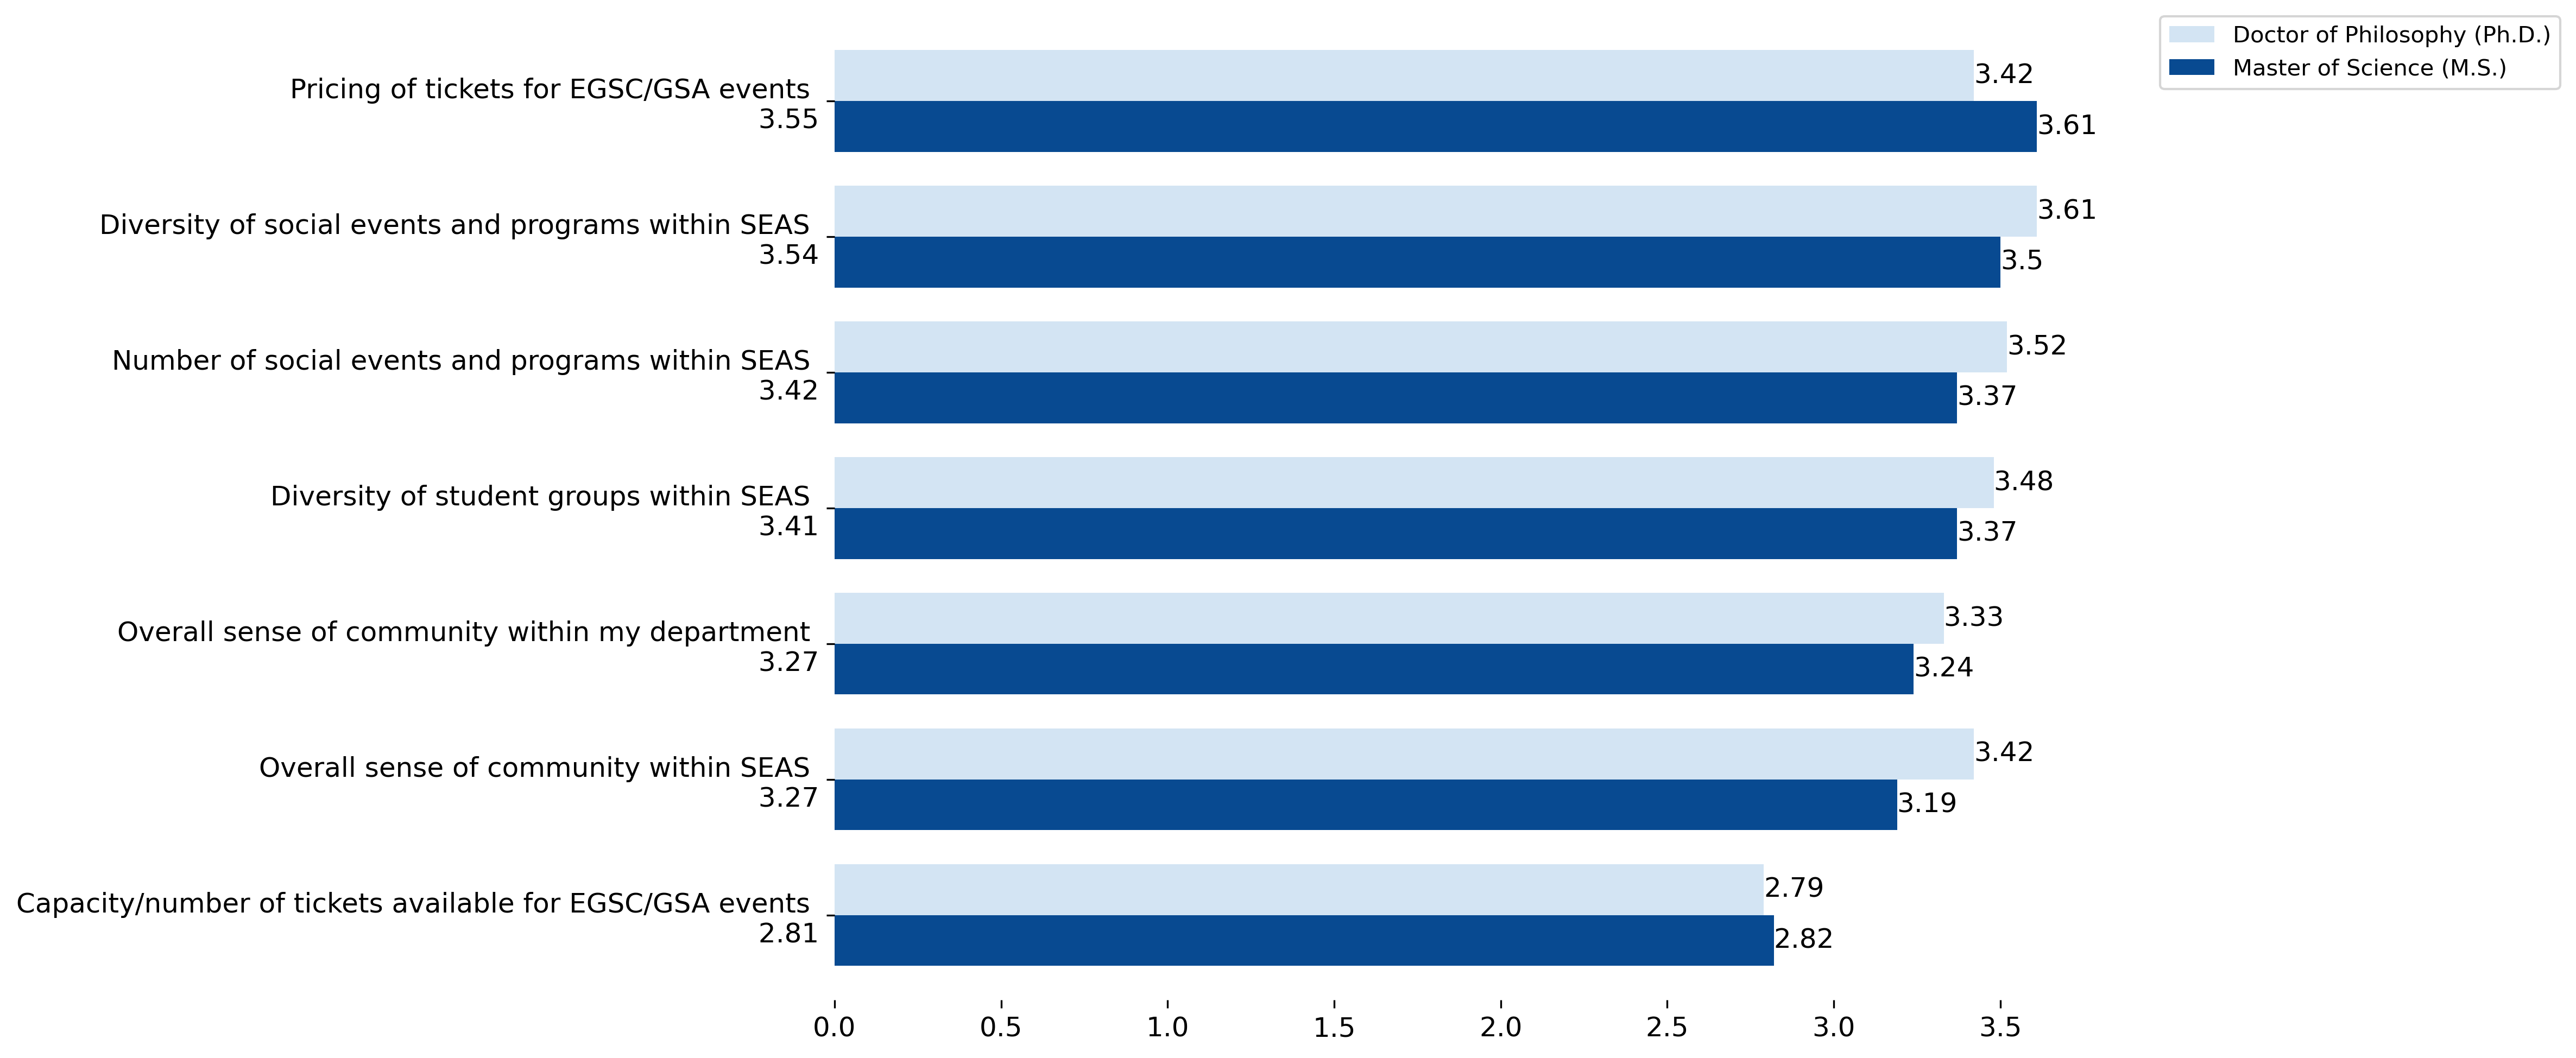

In [81]:
import matplotlib as mpl
cmap2 = mpl.cm.Blues(np.linspace(0.1,0.9,100))
cmap2 = mpl.colors.ListedColormap(cmap2[10:,:-1])
commean = (pd.DataFrame(community.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])

fig,ax=plt.subplots(figsize=(10,8),dpi=300)
#aca_import['degree']=degree
df=community.groupby(['degree']).mean().round(2)#.drop(index='Professional Degree')
#df=df[df.mean().sort_values().index[::-1]]
df = df[commean.index]
dft = df.T
dft.index = df.T.index+' \n '+commean['mean'].astype(str) 
ax=dft.plot.barh(ax=ax,colormap=cmap2,width=0.75, rot=0 ,fontsize=12)
#for i in range(12):
#ax.scatter(satmean.mean(),satmean.index(),s=90,marker='^')
#plt.vlines(x = satmean['mean'], ymin = np.arange(9)-0.2, ymax =np.arange(9)+0.2,colors = 'red')

#ax.set_xticklabels( rotation=0,)
x_offset = -0.1
y_offset = 0.05
for container in ax.containers:
    ax.bar_label(container,fontsize=12)
#for p in ax.patches:
 #   b = p.get_bbox()
  #  val = "{:.2f}".format(b.x1 + b.x0)        
  #  ax.annotate(val, (( b.y1)/2+ x_offset, b.x0 +b.x1+y_offset),fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.invert_yaxis()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

In [213]:
peer = query_data(Q,qq,df2022_ME,'peer',indx=2).copy()
peer.replace('Not Applicable',np.nan,inplace=True)
peer['degree'] = degree
peer.rename(columns={'Other student group-sponsored events (CCV, CEEC, CFEC, DGE, DSISC, ELC, GEEC, GoBME, GradSWE, HinduYUVA, MEGA, PMC, qSTEM, SPICMACAY)':'Other student group-sponsored events','Professional Development and Leadership (PDL) Program.2':'PDL'},inplace=True)

The following events have helped me network with my peers


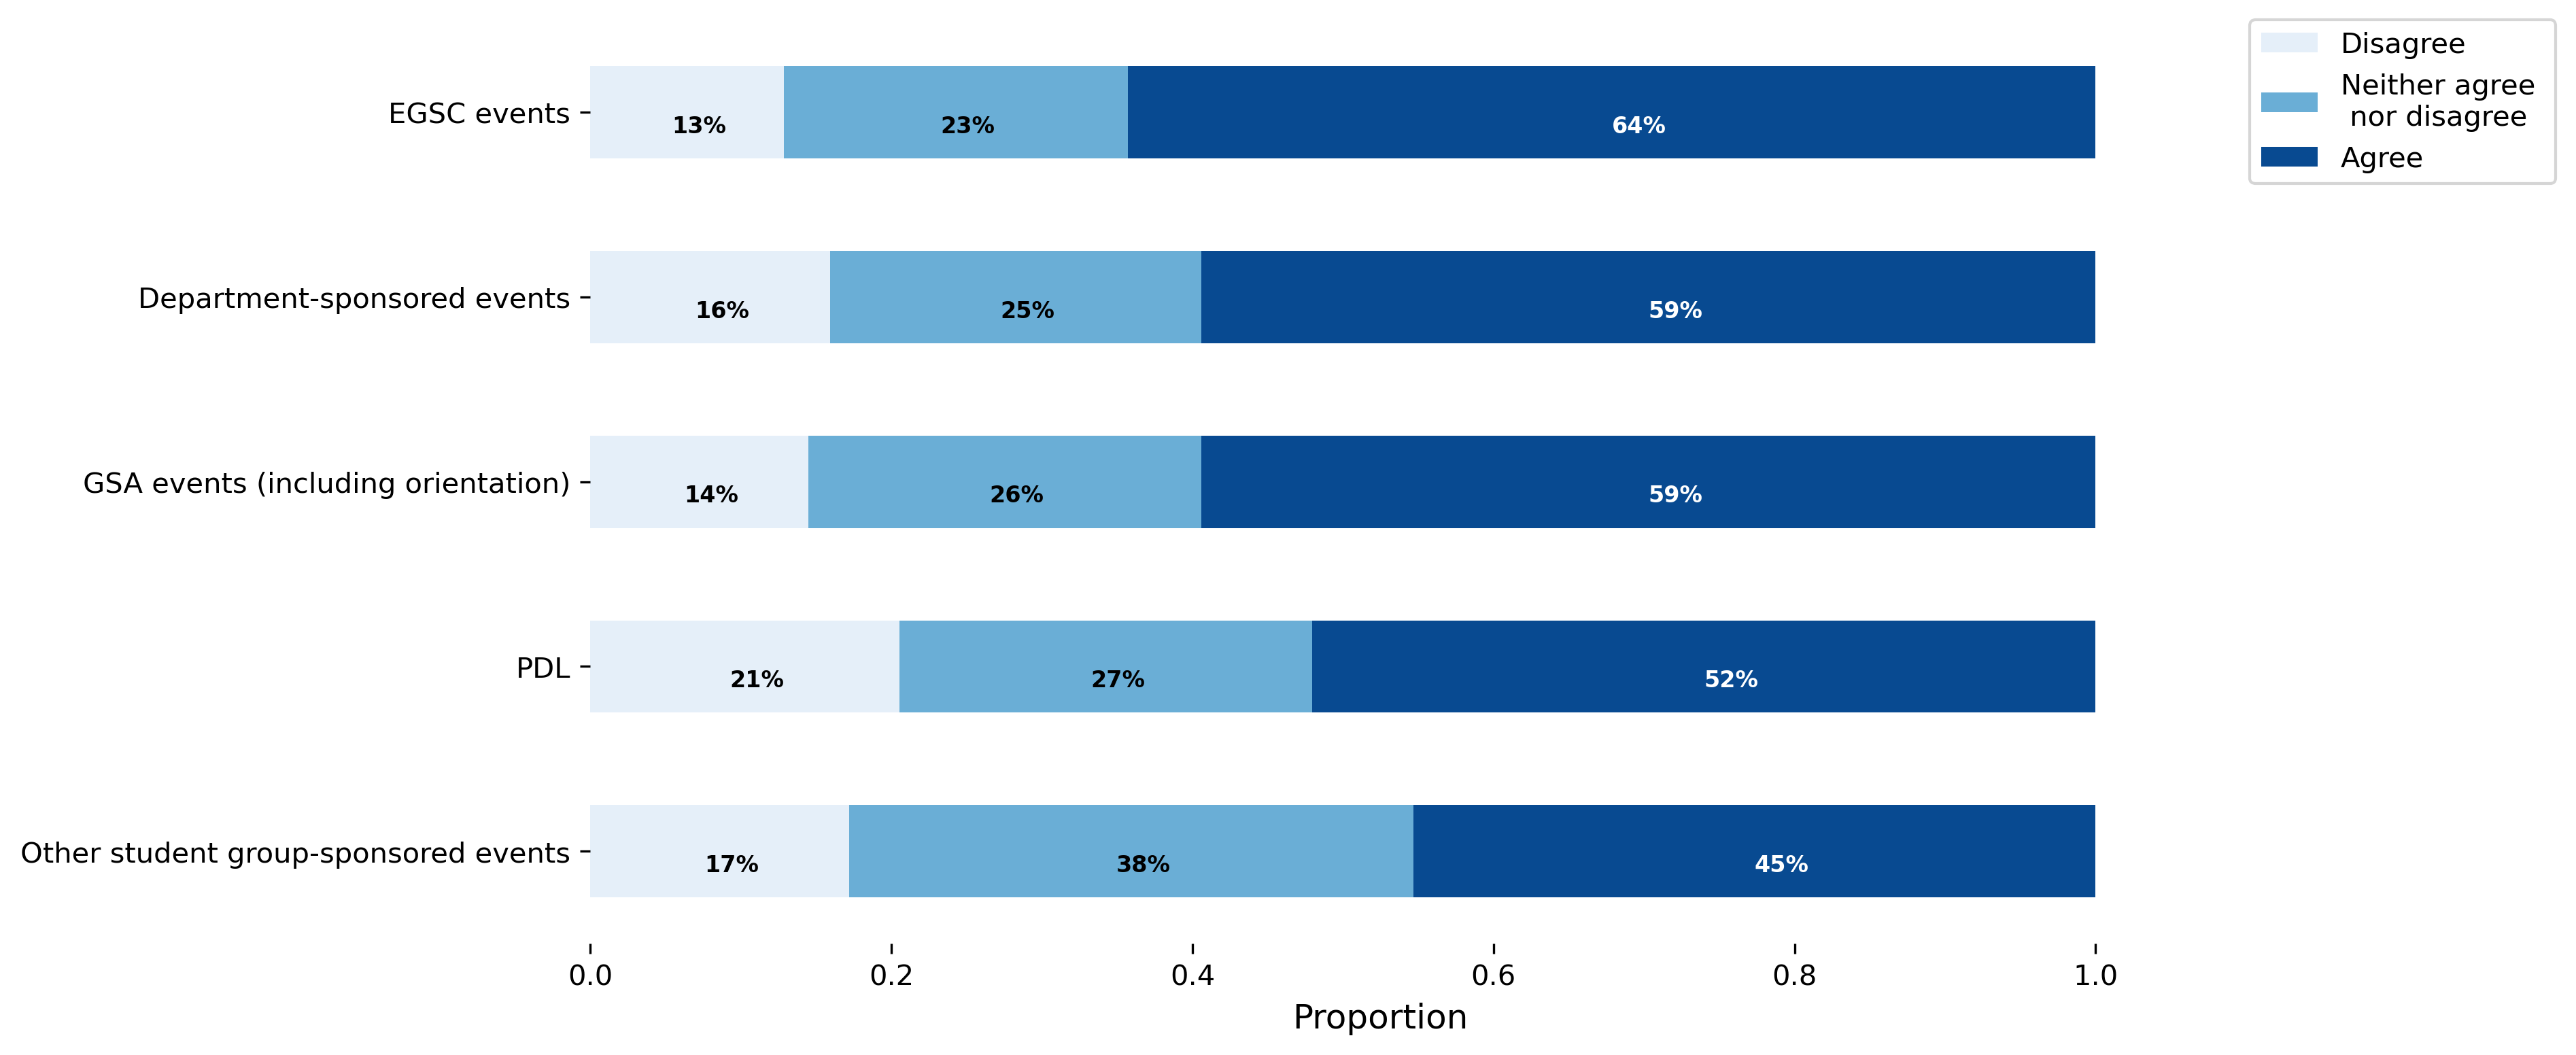

<AxesSubplot:xlabel='Proportion'>

In [214]:
peer.replace(2,1,inplace=True)
peer.replace(4,5,inplace=True)
peer_count=peer.drop(columns='degree').apply(pd.value_counts,axis=0).sort_index()
#community_count.columns = community_count.T.index+' \n '+commean['mean'][community_count.T.index].astype(str) 
plot_3_cat(peer_count)

/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_15751/2707243942.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  peermean = (pd.DataFrame(peer.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])


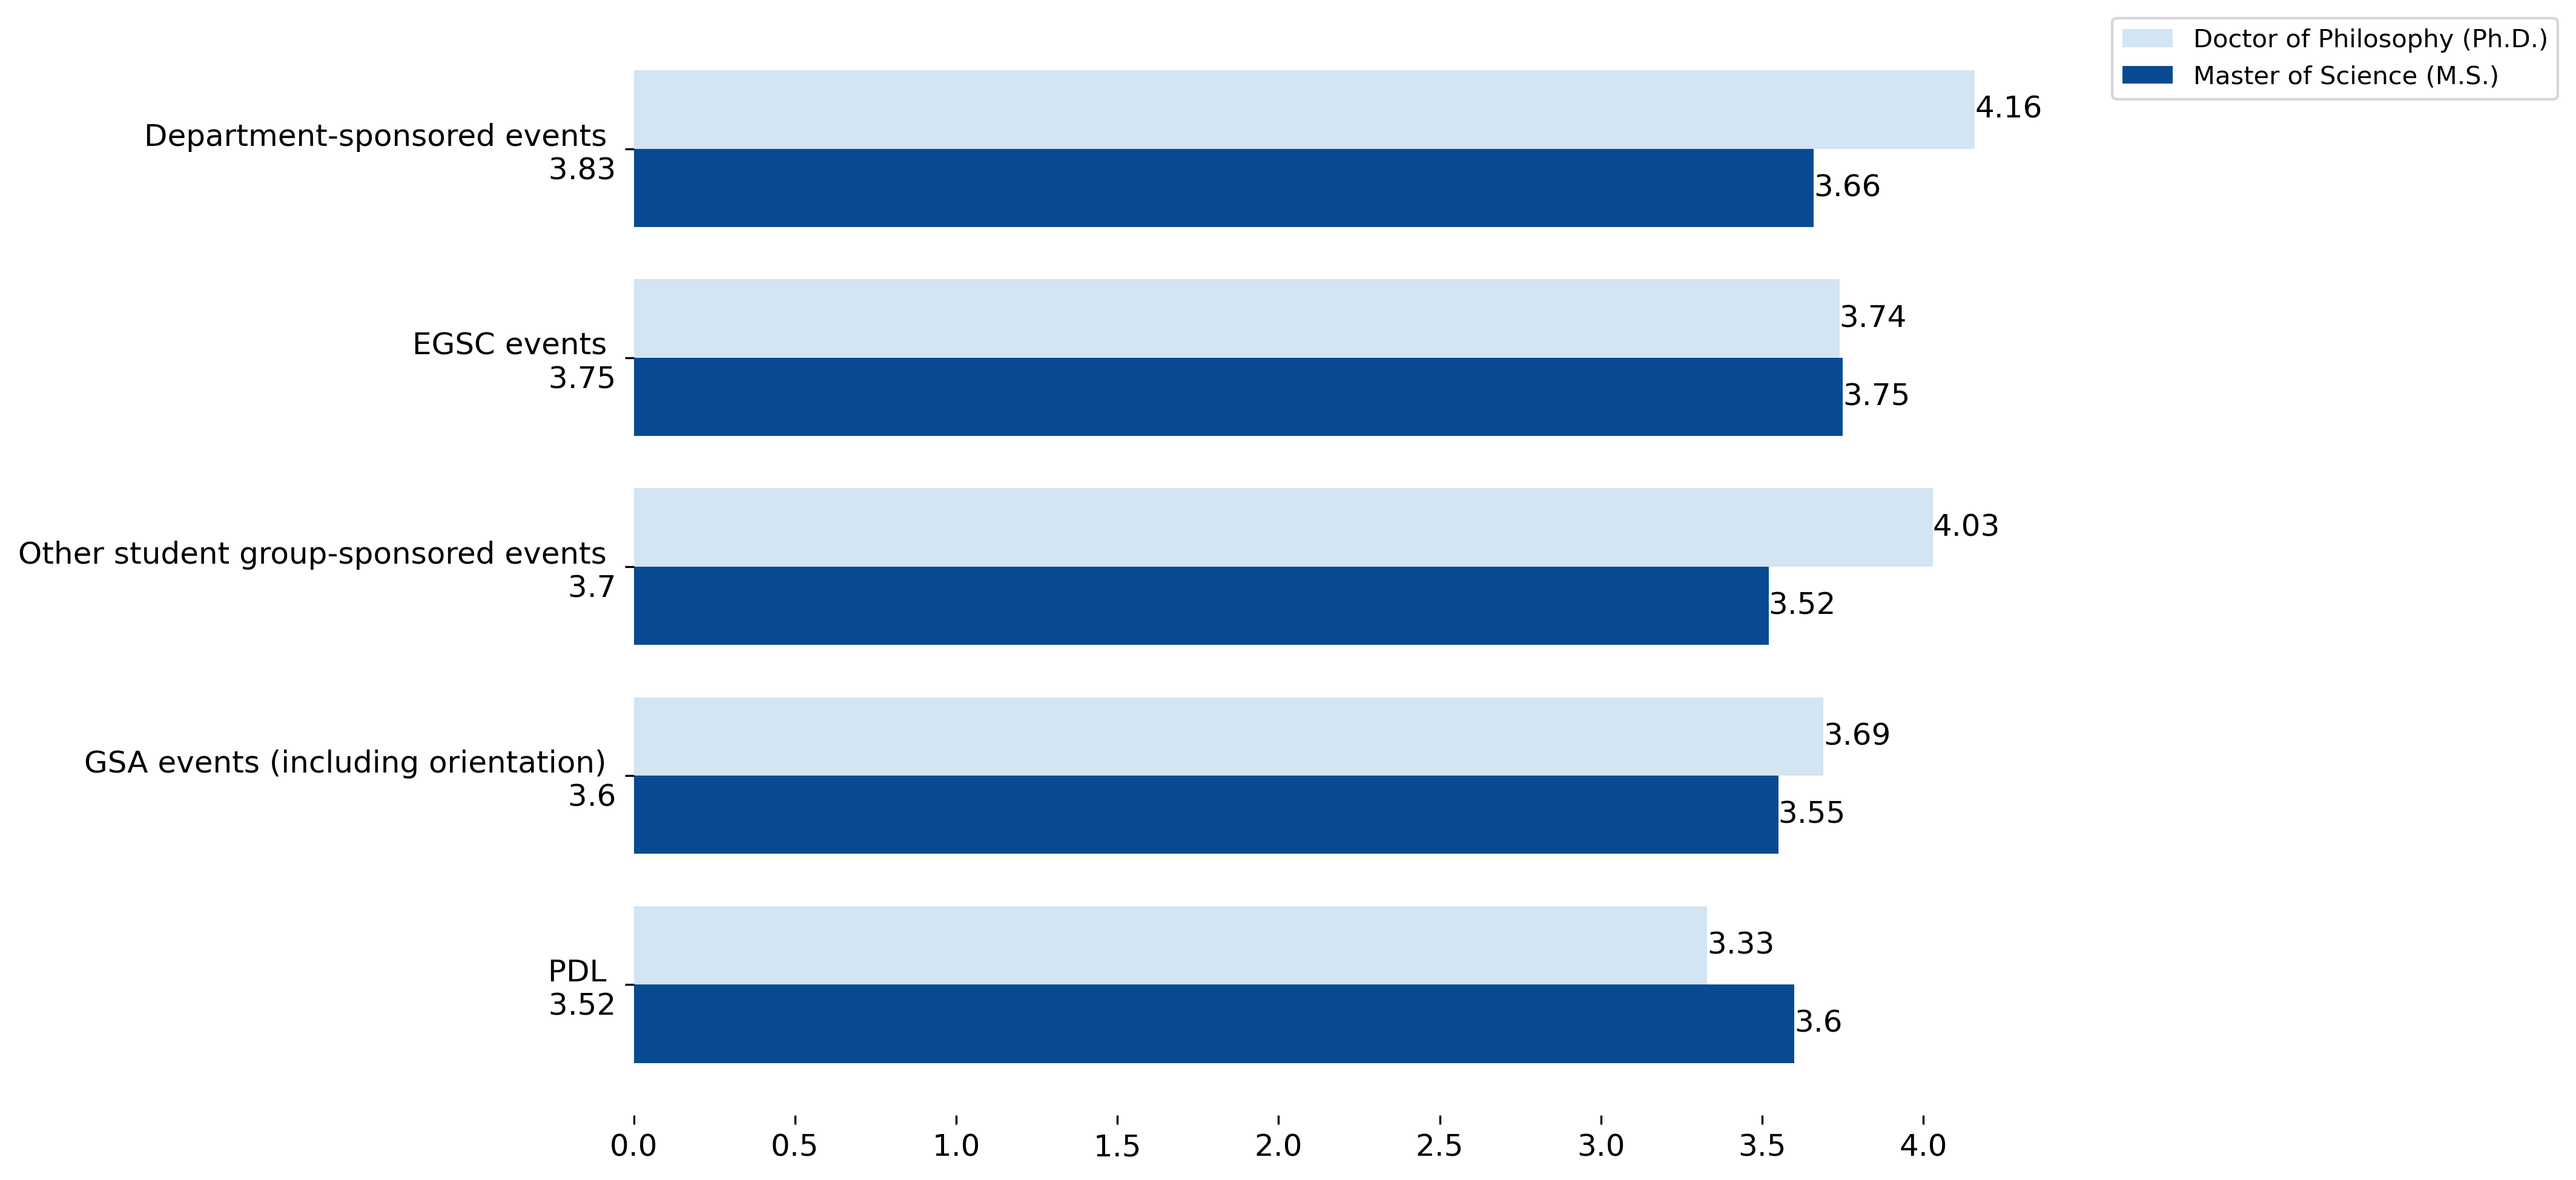

In [83]:
import matplotlib as mpl
cmap2 = mpl.cm.Blues(np.linspace(0.1,0.9,100))
cmap2 = mpl.colors.ListedColormap(cmap2[10:,:-1])
peermean = (pd.DataFrame(peer.mean(axis=0)).round(2).rename(columns={0:'mean'}).sort_values('mean')[::-1])

fig,ax=plt.subplots(figsize=(10,8),dpi=300)
#aca_import['degree']=degree
df=peer.groupby(['degree']).mean().round(2)#.drop(index='Professional Degree')
#df=df[df.mean().sort_values().index[::-1]]
df = df[peermean.index]
dft = df.T
dft.index = df.T.index+' \n '+peermean['mean'].astype(str) 
ax=dft.plot.barh(ax=ax,colormap=cmap2,width=0.75, rot=0 ,fontsize=12)
#for i in range(12):
#ax.scatter(satmean.mean(),satmean.index(),s=90,marker='^')
#plt.vlines(x = satmean['mean'], ymin = np.arange(9)-0.2, ymax =np.arange(9)+0.2,colors = 'red')

#ax.set_xticklabels( rotation=0,)
x_offset = -0.1
y_offset = 0.05
for container in ax.containers:
    ax.bar_label(container,fontsize=12)
#for p in ax.patches:
 #   b = p.get_bbox()
  #  val = "{:.2f}".format(b.x1 + b.x0)        
  #  ax.annotate(val, (( b.y1)/2+ x_offset, b.x0 +b.x1+y_offset),fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.invert_yaxis()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

In [215]:
ori = query_data(Q,qq,df2022_ME,'Orientation',indx=1).copy()
ori.replace(2,1,inplace=True)
ori.replace(4,5,inplace=True)
ori['degree'] = degree
ori_PHD = ori[ori['degree']=='Doctor of Philosophy (Ph.D.)'].drop(columns='degree') #Doctor of Philosophy (Ph.D.) #
ori_MS = ori[ori['degree']=='Master of Science (M.S.)'].drop(columns='degree') #Doctor of Philosophy (Ph.D.) #
ori_MS2PHD = ori[ori['degree']=='M.S. leading to Ph.D.'].drop(columns='degree') 

Orientation helped me become acclimated with:


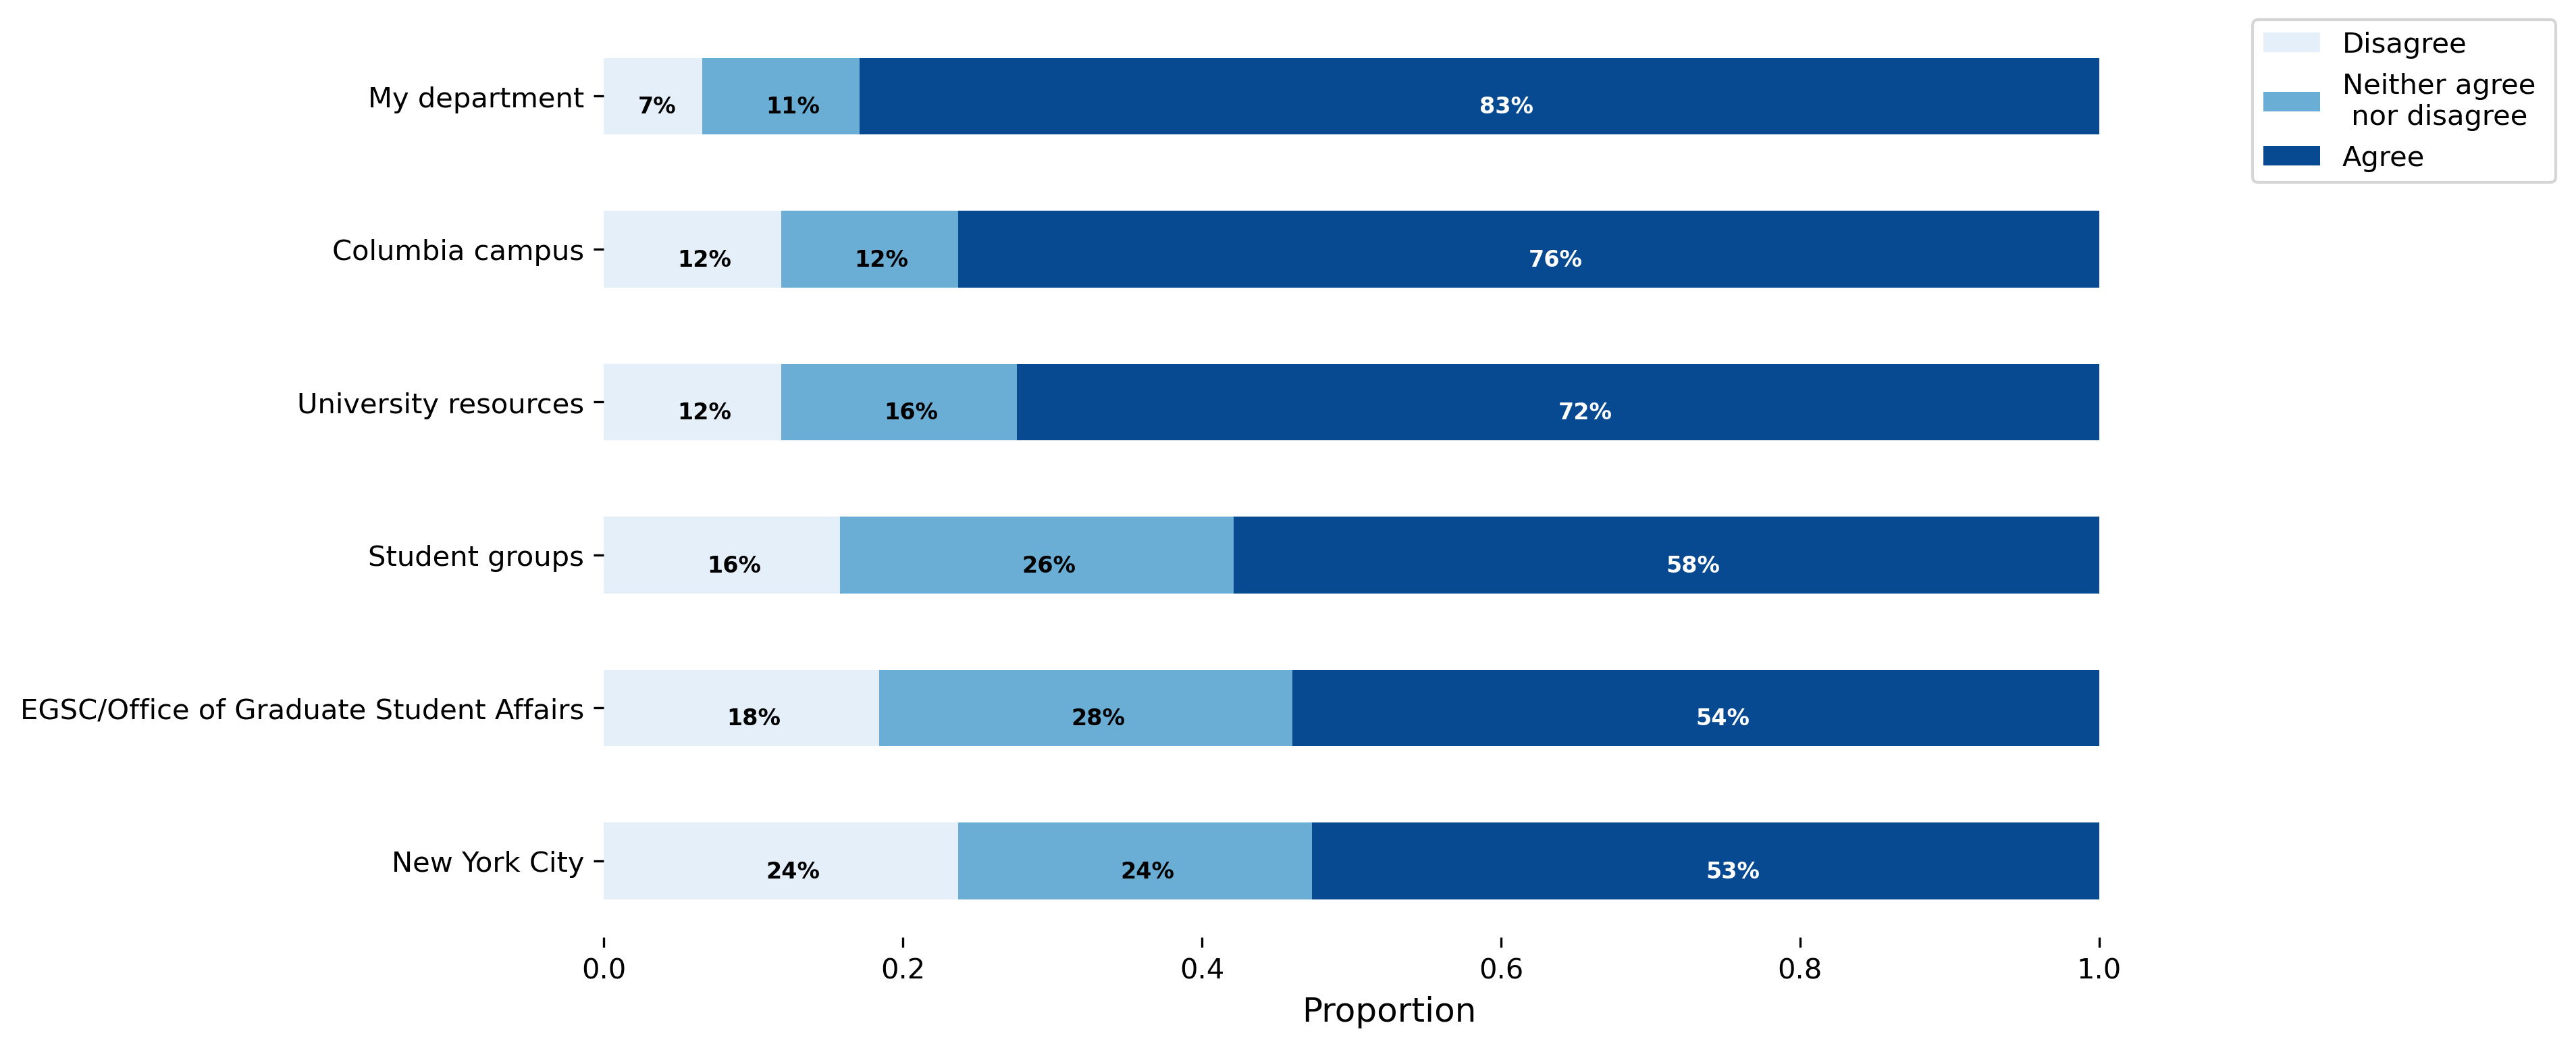

<AxesSubplot:xlabel='Proportion'>

In [216]:
ori_count = ori_MS.apply(pd.value_counts,axis=0).sort_index()
plot_3_cat(ori_count)

In [217]:
hearing =  query_data(Q,qq,df2022_ME,'preferred',indx=1).copy()#.apply(pd.value_counts,axis=0)
hearing['degree'] = degree

hearing.groupby(['degree']).count().T#.value_counts()

What is your preferred way of hearing about graduate student events? (Please check all that apply)


degree,Master of Science (M.S.)
Google Calendar,20
Flyers,10
GSA Newsletter,18
EGSC Newsletter,30
Emails from Graduate Student Affairs office,58
Facebook,9
Twitter Feed,4
EGSC website/Facebook page,11
WeChat,13
WhatsApp,29


In [218]:
query_data(Q,qq,df2022_ME,"Please enter any suggestions you have to improve orientation for future incoming students:",indx=1).copy().value_counts()

Please enter any suggestions you have to improve orientation for future incoming students:


Open-Ended Response.8                                                                        
A walkthrough on course work and time management schedule and clarity on working on homework     1
Breakout rooms help again! Apart from that everything is great.                                  1
I think orientation was good enough.                                                             1
I would like to have a longer orientation for more socialization (DS)                            1
Interaction with seniors and scocial events with seniors would be helpful                        1
Nothing                                                                                          1
more interactive and networking event                                                            1
dtype: int64

In [219]:
query_data(Q,qq,df2022_ME,'Please share any additional feedback you have on current social events and/or suggestions for future social events:',indx=1).value_counts()

Please share any additional feedback you have on current social events and/or suggestions for future social events:


Open-Ended Response.6                                                                                                                                                                                                                                                                                                                                          
#NAME?                                                                                                                                                                                                                                                                                                                                                             1
Great so far!                                                                                                                                                                                                                                                                                      